# Import Scanpy & other packages

In [1]:
import scanpy as sc

import numpy as np
import pandas as pd
%matplotlib inline

from datascience import Table

## Setting up Data

`verbosity`- Level 0: only show ‘error’ messages. Level 1: also show ‘warning’ messages. Level 2: also show ‘info’ messages. Level 3: also show ‘hint’ messages. Level 4: also show very detailed progress for ‘debug’ging.

In [2]:
sc.settings.verbosity = 3

`set_figure_params`- Set resolution/size, styling and format of figures 
* `dpi(dots per image)`- low dpi yields small inline figures. 
    * Resolution of rendered figures – this influences the size of figures in notebooks.

In [3]:
sc.settings.set_figure_params(dpi = 80)

`print_header()`- Versions that might influence the numerical results. same thing as print `print_versions()` 

In [4]:
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.18.5 scipy==1.5.4 pandas==1.1.3 scikit-learn==0.24.0 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0


## Load Data

`results_file` the file that will store the analysis results

In [5]:
results_file = 'write/pbmc3k.h5ad' 

reading into data

In [6]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


Making Variable Names unique 


this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata.var_names_make_unique()  

In [8]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

This means that there are `2700 x 32738`

                      2700 cells             32738 genes

# Data Preprocessing

Data Preprocessing has two main parts:

1. Data Aquisition
        * alignment, de-duplication, unique reads, quantificiation
        
2. Data Cleaning 
        * quality control 

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:00)


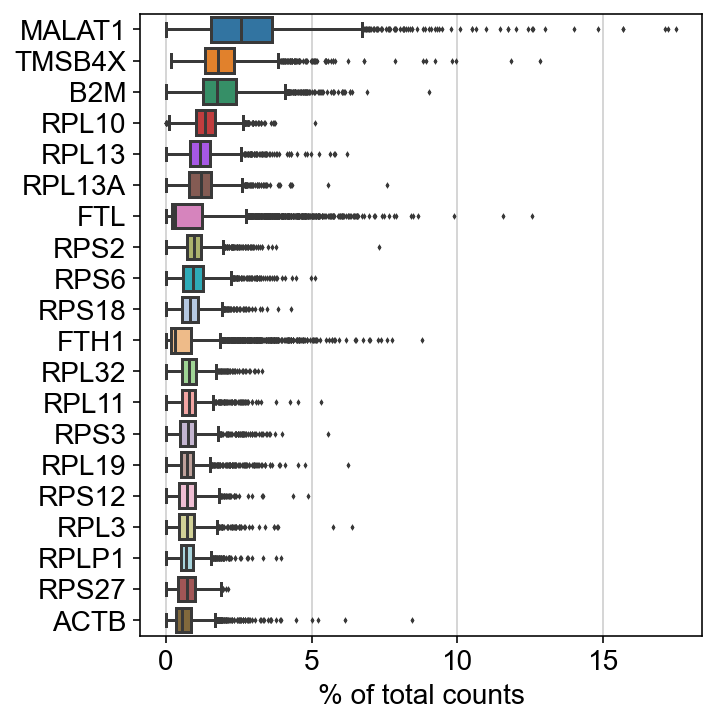

In [9]:
%matplotlib inline
sc.pl.highest_expr_genes(adata, n_top=20) 

## Quality Control

**Selection and filtration of cells and genes based on quality metrics**

Low-quality cells would interfere with downstream analyses. These cells may have been damaged during processing and may not have been fully captured by the sequencing protocol.

Need to remove low quality cells at the start of analysis

- **Cell Size** total sum of counts acroos all genes for each cells 

Cells with small sizes are considered to be of low quality: RNA los during library preparation

In [10]:
sc.pp.filter_cells(adata, min_genes = 200)

- **Number of expressed genes** number of genes with non-zero counts for each cells 

Low expressed gnenes are result of poor-quality cells followed by high PCR amplicfication of remaining RNA

In [11]:
sc.pp.filter_genes(adata, min_cells = 3)

filtered out 19024 genes that are detected in less than 3 cells


* **Proportion of reads mapped to genes in the mitochondirial genome** 

High concentration of mitochondrial genes are a result of damaged cells where endegenous RNA escapes or degrades. As mitochondira has it's own cell membranes it is often the last DNA/RNA in damaged cells to degrade and hence occurs in high quantities during sequencing

all andata variable names ([property of anndata](https://anndata.readthedocs.io/en/latest/anndata.AnnData.var_names.html) )

In [12]:
adata.var_names

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)

want to filter out the ones that are mitochondrial --> ones that start with MT

[use pandas string methods to get array of booleans that say if mitochondrial gene or not](https://www.tutorialspoint.com/python_pandas/python_pandas_working_with_text_data.htm)

In [13]:
adata.var_names.str.startswith('MT-')

array([False, False, False, ..., False, False, False])

anndata annotation of all mitochondrial genes 

In [14]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')

**Quality metrics for mitochondrial genes**

In [15]:
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

`adata.obs` - one dimenstional annotation of (`pd.DataFrame`)

In [16]:
adata.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACATACAACCAC-1      781                779        2419.0             73.0   
AAACATTGAGCTAC-1     1352               1352        4903.0            186.0   
AAACATTGATCAGC-1     1131               1129        3147.0             28.0   
AAACCGTGCTTCCG-1      960                960        2639.0             46.0   
AAACCGTGTATGCG-1      522                521         980.0             12.0   
...                   ...                ...           ...              ...   
TTTCGAACTCTCAT-1     1155               1153        3459.0             73.0   
TTTCTACTGAGGCA-1     1227               1224        3443.0             32.0   
TTTCTACTTCCTCG-1      622                622        1684.0             37.0   
TTTGCATGAGAGGC-1      454                452        1022.0             21.0   
TTTGCATGCCTCAC-1      724                723        1984.0             16.0   

                  pct_counts_mt  
AAACATACAACCAC-1       3.017776  
AAACATTGAGCTAC-1       3.793596  
AAACATTGATCAGC-1       0.889736  
AAACCGTGCTTCCG-1       1.743085  
AAACCGTGTATGCG-1       1.224490  
...                         ...  
TTTCGAACTCTCAT-1       2.110436  
TTTCTACTGAGGCA-1       0.929422  
TTTCTACTTCCTCG-1       2.197150  
TTTGCATGAGAGGC-1       2.054795  
TTTGCATGCCTCAC-1       0.806452  

[2700 rows x 5 columns]

Violin plot of keys accessing fields of obs

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_c

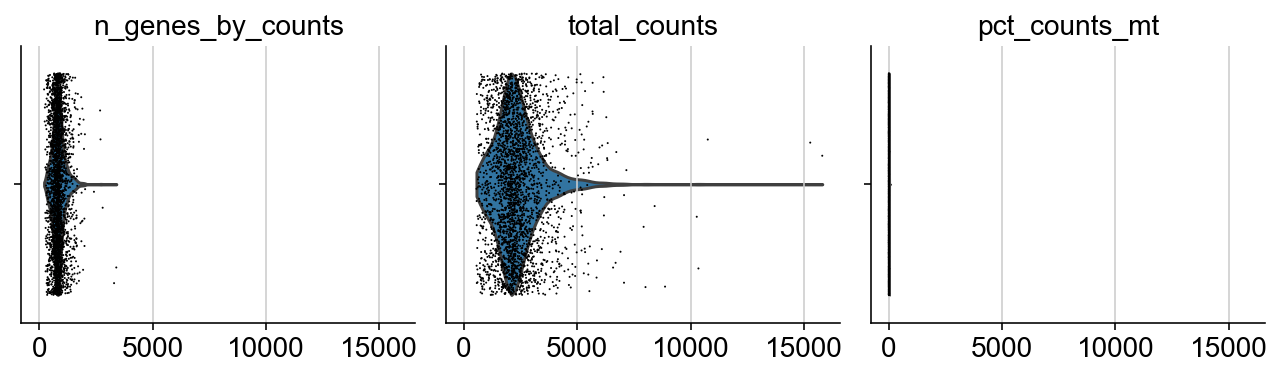

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, )

seaborn problem but this is what the graphs look like normally
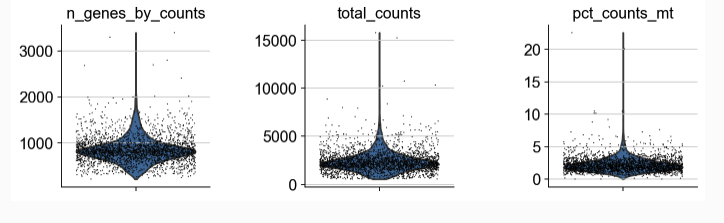

need to remove cells that have too many mitochondiral genes or too many total counts, look at scatter plot to get better picture

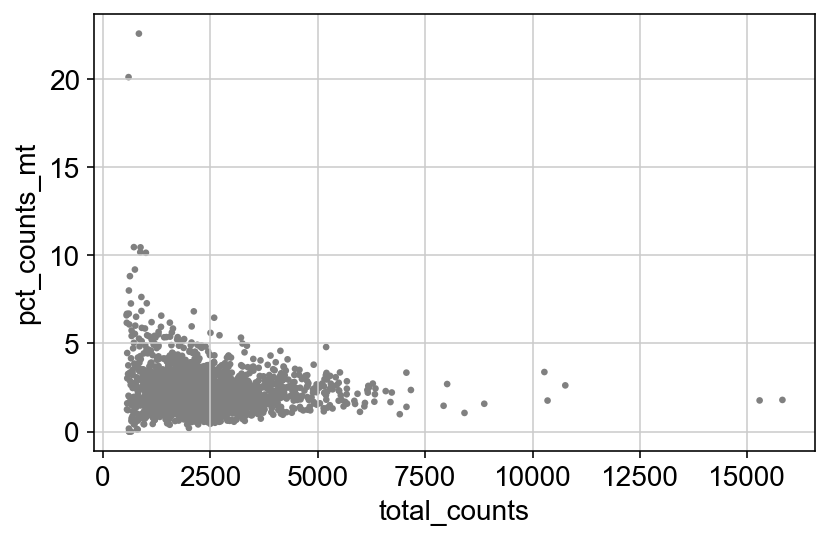

In [18]:
sc.pl.scatter(adata, x = 'total_counts', y='pct_counts_mt')

bigger than 5 pct_counts_mt is where outliers begin to start

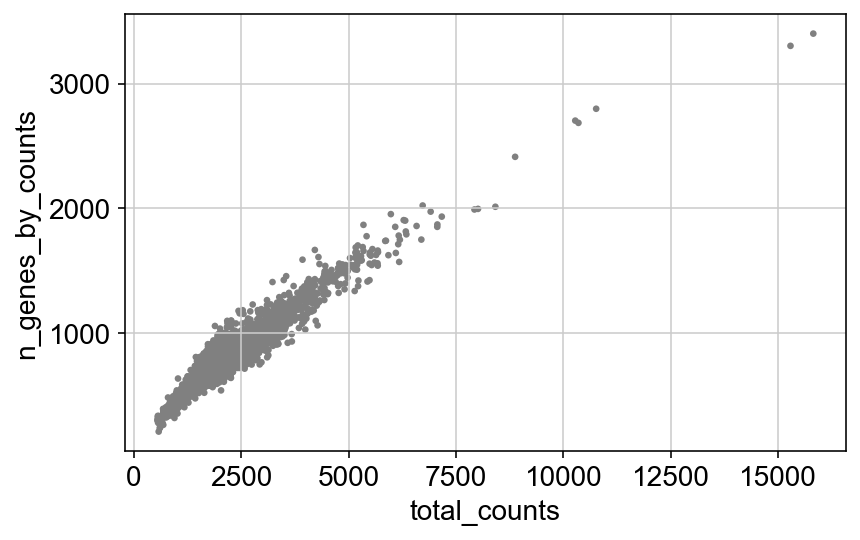

In [19]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Filter by splicing Anndata object: 25000 is where outliers begin to form

In [20]:
adata.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACATACAACCAC-1      781                779        2419.0             73.0   
AAACATTGAGCTAC-1     1352               1352        4903.0            186.0   
AAACATTGATCAGC-1     1131               1129        3147.0             28.0   
AAACCGTGCTTCCG-1      960                960        2639.0             46.0   
AAACCGTGTATGCG-1      522                521         980.0             12.0   
...                   ...                ...           ...              ...   
TTTCGAACTCTCAT-1     1155               1153        3459.0             73.0   
TTTCTACTGAGGCA-1     1227               1224        3443.0             32.0   
TTTCTACTTCCTCG-1      622                622        1684.0             37.0   
TTTGCATGAGAGGC-1      454                452        1022.0             21.0   
TTTGCATGCCTCAC-1      724                723        1984.0             16.0   

                  pct_counts_mt  
AAACATACAACCAC-1       3.017776  
AAACATTGAGCTAC-1       3.793596  
AAACATTGATCAGC-1       0.889736  
AAACCGTGCTTCCG-1       1.743085  
AAACCGTGTATGCG-1       1.224490  
...                         ...  
TTTCGAACTCTCAT-1       2.110436  
TTTCTACTGAGGCA-1       0.929422  
TTTCTACTTCCTCG-1       2.197150  
TTTGCATGAGAGGC-1       2.054795  
TTTGCATGCCTCAC-1       0.806452  

[2700 rows x 5 columns]

In [21]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

In [22]:
adata = adata[adata.obs.pct_counts_mt < 5, :] 

In [23]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Visual check of filtering success now there are less cells

## Normalization and scaling

 `Database normalization` systematic approach of decomposing tables to eliminate data redundancy(repetition) and undesirable characteristics like Insertion, Update and Deletion Anomalies.

A distinctive feature of scRNA-seq data is the presence of zero-inflated counts due to reasons such as dropout or transient gene expression. To account for this feature, normalization must be performed; normalization is necessary to remove cell-specific bias, which can affect downstream applications (e.g., determination of differential gene expression).
> There is inflated gene counts from the low quality cells counted so you need to do normalization to take out skewing from low quality cells. 

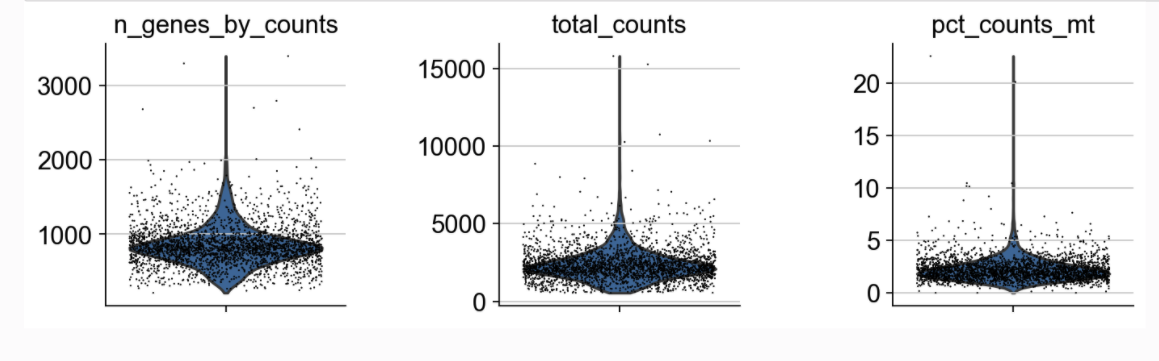

threshold is 10,000 when looking at totla counts but also most people put 10,000 when doing normalization, can also put the median number of counts per cell.

In [24]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


The normalized counts should be log-transformed afterwards to adjust for the mean-variance relationship.

With log-transformation, the differences in the log-values represent log-fold changes in expression. Log-transformation focuses on promoting contributions from genes with strong relative differences (e.g. a gene that is expressed at an average count of 50 in cell type A and 10 in cell type B rather than a gene that is expressed at an average count of 1100 in A and 1000 in B).

>need to logarithimize data to account for mean-variance relationship: represents log-fold changes in expression 

            1100 cell type A  & 1000 in cell type B  -----> 50 cell type A & 10 cell type B 

In [25]:
sc.pp.log1p(adata)

## Selection of Features

Because cells are compared based on gene expression profiles --> choice of genes to use have impact on behavior of clustering and dimensionality reduction 

**need to remove genes with random noise** ---> most variable genes (genes highly expressed in some cells and lowly in other) *assume increased variation in genes are due to biological differences rather than noise*

In [26]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


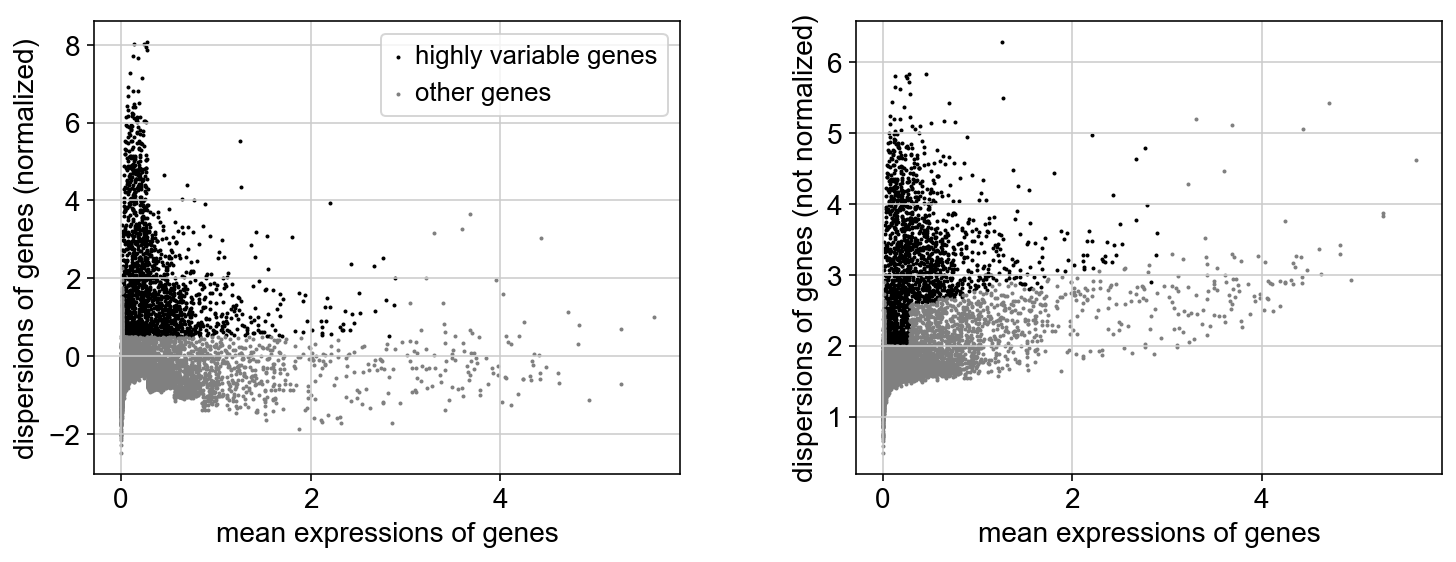

In [27]:
sc.pl.highly_variable_genes(adata)

now genes are marked if the are highly variable or not

In [28]:
adata.var

gene_ids  n_cells     mt  n_cells_by_counts  \
AL627309.1     ENSG00000237683        9  False                  9   
AP006222.2     ENSG00000228463        3  False                  3   
RP11-206L10.2  ENSG00000228327        5  False                  5   
RP11-206L10.9  ENSG00000237491        3  False                  3   
LINC00115      ENSG00000225880       18  False                 18   
...                        ...      ...    ...                ...   
AC145212.1     ENSG00000215750       16  False                 16   
AL592183.1     ENSG00000220023      323  False                323   
AL354822.1     ENSG00000215615        8  False                  8   
PNRC2-1        ENSG00000215700      110  False                110   
SRSF10-1       ENSG00000215699       69  False                 69   

               mean_counts  pct_dropout_by_counts  total_counts  \
AL627309.1        0.003333              99.666667           9.0   
AP006222.2        0.001111              99.888889           3.0   
RP11-206L10.2     0.001852              99.814815           5.0   
RP11-206L10.9     0.001111              99.888889           3.0   
LINC00115         0.006667              99.333333          18.0   
...                    ...                    ...           ...   
AC145212.1        0.006667              99.407407          18.0   
AL592183.1        0.134815              88.037037         364.0   
AL354822.1        0.002963              99.703704           8.0   
PNRC2-1           0.042963              95.925926         116.0   
SRSF10-1          0.025926              97.444444          70.0   

               highly_variable     means  dispersions  dispersions_norm  
AL627309.1               False  0.013556     1.432845         -0.624328  
AP006222.2               False  0.004696     1.458631         -0.573416  
RP11-206L10.2            False  0.005673     1.325459         -0.836358  
RP11-206L10.9            False  0.002644     0.859264         -1.756848  
LINC00115                False  0.027437     1.457477         -0.575693  
...                        ...       ...          ...               ...  
AC145212.1               False  0.027441     1.784637          0.070275  
AL592183.1               False  0.485051     1.859941         -0.437388  
AL354822.1               False  0.012157     1.781924          0.064919  
PNRC2-1                  False  0.160366     1.567491         -0.358474  
SRSF10-1                 False  0.100255     1.544864         -0.403150  

[13714 rows x 11 columns]

Need to set the raw attribute of andata object to normalized and logarthimized gene expression for later use 

In [29]:
adata.raw = adata

Do filtering to only include highly variable genes

In [30]:
adata = adata[:, adata.var.highly_variable]

In [31]:
adata.var

gene_ids  n_cells     mt  n_cells_by_counts  mean_counts  \
TNFRSF4  ENSG00000186827      155  False                155     0.077407   
CPSF3L   ENSG00000127054      202  False                202     0.094815   
ATAD3C   ENSG00000215915        9  False                  9     0.009259   
C1orf86  ENSG00000162585      501  False                501     0.227778   
RER1     ENSG00000157916      608  False                608     0.298148   
...                  ...      ...    ...                ...          ...   
ICOSLG   ENSG00000160223       34  False                 34     0.016667   
SUMO3    ENSG00000184900      570  False                570     0.292963   
SLC19A1  ENSG00000173638       31  False                 31     0.018519   
S100B    ENSG00000160307       94  False                 94     0.076667   
PRMT2    ENSG00000160310      588  False                588     0.275926   

         pct_dropout_by_counts  total_counts  highly_variable     means  \
TNFRSF4              94.259259         209.0             True  0.277410   
CPSF3L               92.518519         256.0             True  0.385194   
ATAD3C               99.666667          25.0             True  0.038252   
C1orf86              81.444444         615.0             True  0.678283   
RER1                 77.481481         805.0             True  0.814813   
...                        ...           ...              ...       ...   
ICOSLG               98.740741          45.0             True  0.082016   
SUMO3                78.888889         791.0             True  0.804815   
SLC19A1              98.851852          50.0             True  0.058960   
S100B                96.518519         207.0             True  0.286282   
PRMT2                78.222222         745.0             True  0.816647   

         dispersions  dispersions_norm  
TNFRSF4     2.086050          0.665406  
CPSF3L      4.506987          2.955005  
ATAD3C      3.953486          4.352607  
C1orf86     2.713522          0.543183  
RER1        3.447533          1.582528  
...              ...               ...  
ICOSLG      2.585818          1.652185  
SUMO3       4.046776          2.431045  
SLC19A1     3.234231          2.932458  
S100B       3.042992          1.078783  
PRMT2       2.774169          0.629058  

[1838 rows x 11 columns]

only highly variable genes are kept and number of genes went down

## Scaling the Data

> Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.

Regress out (mostly) unwanted sources of variation.

In [32]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:12)


> Scale each gene to unit variance. Clip values exceeding standard deviation 10.

Scale data to unit variance and zero mean.

In [33]:
sc.pp.scale(adata, max_value =10)

In [34]:
tbl = Table.from_df(adata.var)
tbl.show(5)

In [35]:
np.count_nonzero(tbl.column('std') >= 10)

0

# Dimensionality Reduction

**Goal**: compare cells based on expression across genes --> identify similar transcriptonmic profiles

Each gene = dimension of data --> thousands of data = thousands of dimensions!!

same biological process --> expression of diff't genes correlated --> can be compressed into single dimension 


## Principal Component Analysis

* **dimensionality reduction technique** 
   * identify axes in high dimensions that **capture largest amount of variation**
        * `principal component(first axis)` *captures greatest variance*
        * `next principal component` is orthogonal to first and *capture greatest of the remaining amount of variance*
* **applying to scRNA-Seq** - multiple genes affected by same biological process and randomness affects each gene independently
    * top PCs: represent biological signal, **dominant factors of heterogenity** 
    * later PCs: *noise is concentrated*
    * ***restricting downstream analyses to top PCSs will reduce dimensionality of data focusing on biological signal and removing noise***

In [36]:
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


### How is PCA Stored in Anndata? 

In [37]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

3 new objects (`uns`, `obsm`, `varm`) have been added to the AnnData object with information that seem related to PCA.

`uns` is an unstructured annotation, `obsm` multi-dimensional annotation of the observations (i.e. genes) and `varm` multi-dimensional annotation of the variables (i.e. cells).

**What information is stored in `uns` regarding the PCA?**

`uns` is storing:
* ratio of explained variance by PC's, sortedd by PC's as a one column table

In [38]:
adata.uns

OverloadedDict, wrapping:
	{'log1p': {'base': None}, 'hvg': {'flavor': 'seurat'}, 'pca': {'params': {'zero_center': True, 'use_highly_variable': True}, 'variance': array([32.11044  , 18.718643 , 15.607317 , 13.235285 ,  4.8022647,
        3.985928 ,  3.5262358,  3.2334418,  3.1212   ,  3.075258 ,
        2.9980755,  2.9595194,  2.951789 ,  2.9442527,  2.913876 ,
        2.8990357,  2.880683 ,  2.8646863,  2.8430667,  2.8357513,
        2.8314233,  2.8182364,  2.803552 ,  2.7999864,  2.7889566,
        2.778101 ,  2.7705753,  2.7602236,  2.75386  ,  2.7459543,
        2.7371838,  2.7341254,  2.722202 ,  2.7123094,  2.7024772,
        2.7000456,  2.683852 ,  2.6790495,  2.6769054,  2.673994 ,
        2.6648529,  2.6573098,  2.6511762,  2.6417756,  2.6329703,
        2.6295207,  2.6245286,  2.618377 ,  2.6180005,  2.6018648],
      dtype=float32), 'variance_ratio': array([0.02012818, 0.01173364, 0.00978333, 0.00829644, 0.00301026,
       0.00249855, 0.00221039, 0.00202686, 0.0019565 , 0.0

**What information is stored in `obsm` regarding the PCA?**

`obsm` is storing the PCA coordinated for the *cells* as a table with rows being the cells, 

the columns the PC's 

the values the PC's coordinate for cell and PC 

* Multi-dimensional annotation of observations 

In [39]:
adata.obsm

AxisArrays with keys: X_pca

**What information is stored in `varm` regarding the PCA?**

`varm` is storing the PCA coordinates for the *genes* as a table with the rows being the genes, 

the columns the PCs 

the values the PCs coordinate for gene and PC

* Multi-dimensional annotation of variables/feature

In [40]:
adata.varm

AxisArrays with keys: PCs

### Looking at all cell expression of CST3 gene captured Principal Component 1 & Principal Component 2

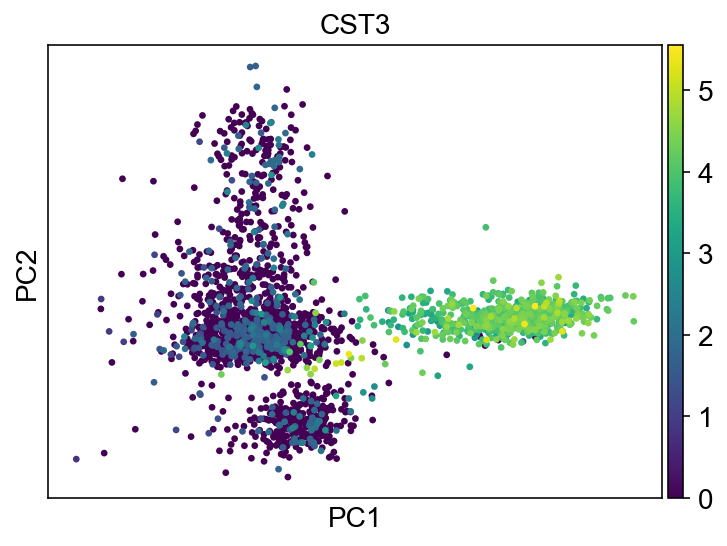

In [41]:
sc.pl.pca(adata,color= 'CST3')

If we look at the x axis (PC1), we see the greatest variation in between cells but if you look at the y axis (PC2), we don't see as much variation under the cells (differences in colors as it goes up in the y-axis. Further justifying to us that **PC1 captures the greatest variance across cells**

**Values for the genes the most valued in the Principal Component--> the gene that has the most variation for all the cells as seen in the plot above**

CST3 has the most variation across all the cells for the the first principal component 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


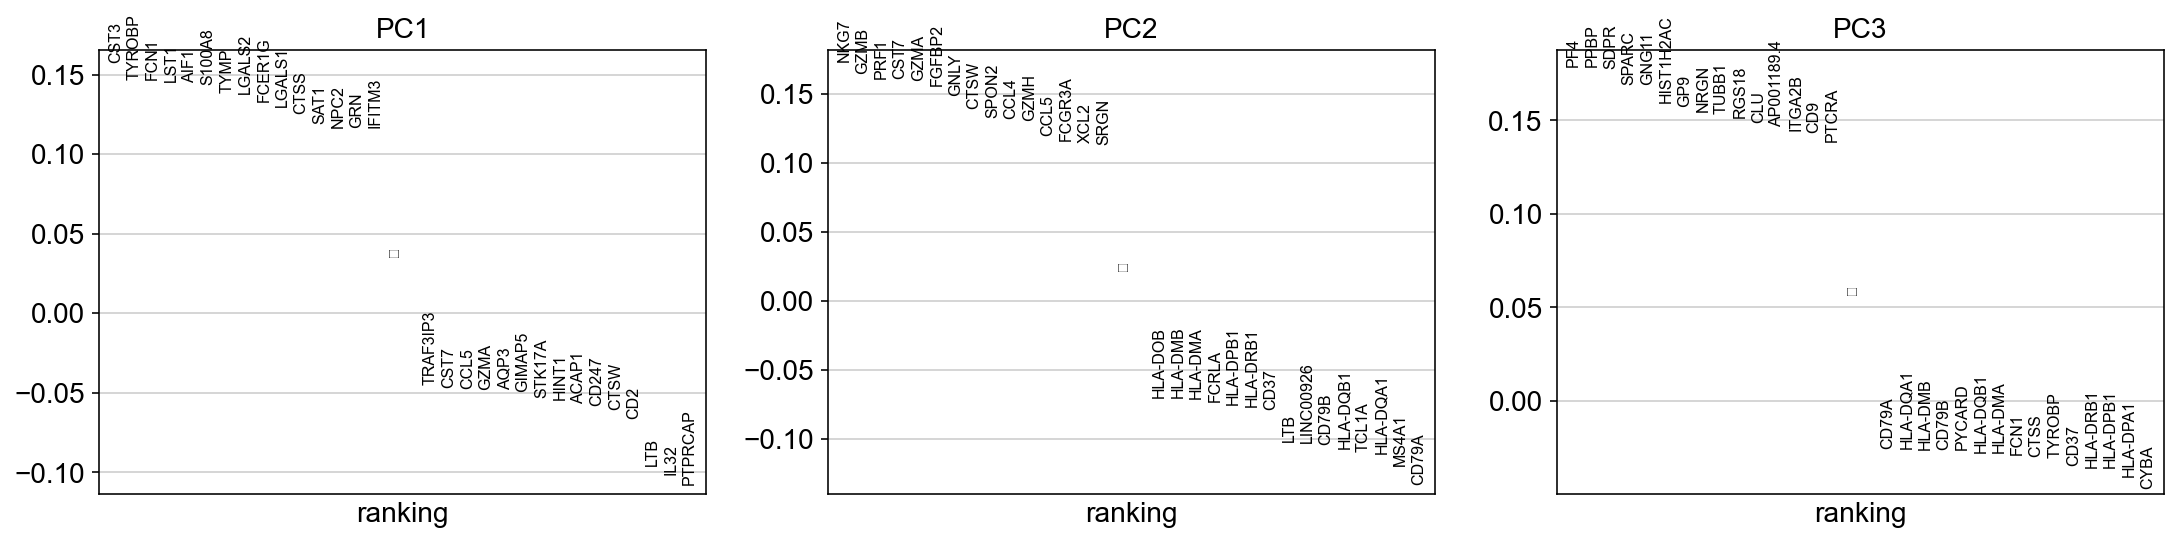

In [42]:
sc.pl.pca_loadings(adata, [1,2,3])

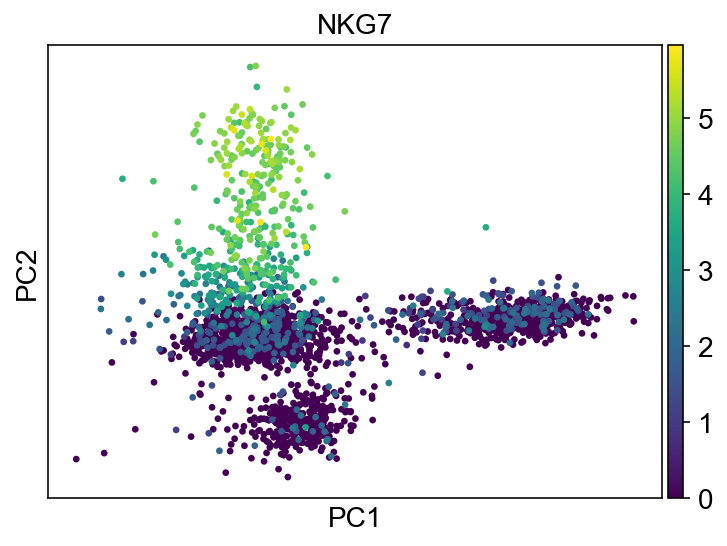

In [43]:
sc.pl.pca(adata,color= 'NKG7')

 **more variation in PC2 than PC1** as shown in the plot above

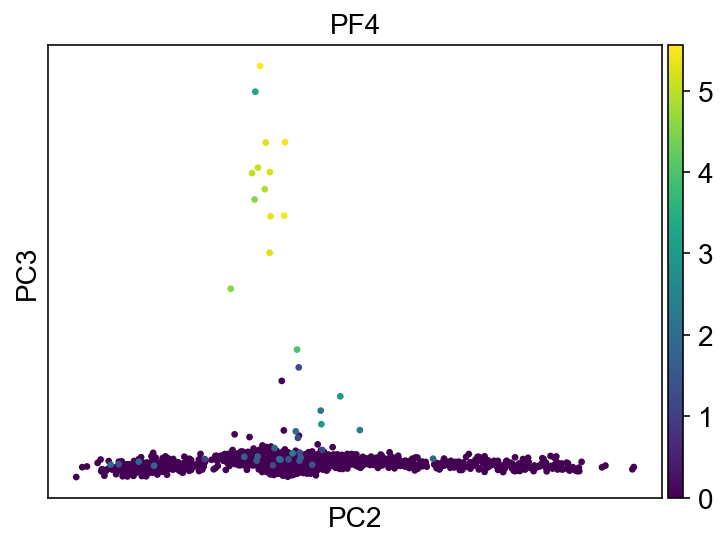

In [44]:
sc.pl.pca(adata, color= 'PF4', components = [2,3])

 **more variation in PC3 than PC3** as shown in the plot above

## Determination of the number of Principal Components to keep

* we have 50 PC, how many do we keep?


* more PC --> more noise but also more biological signal

generate elbow plot and choose the number of PCS that are high in percentage until there's not much of a difference

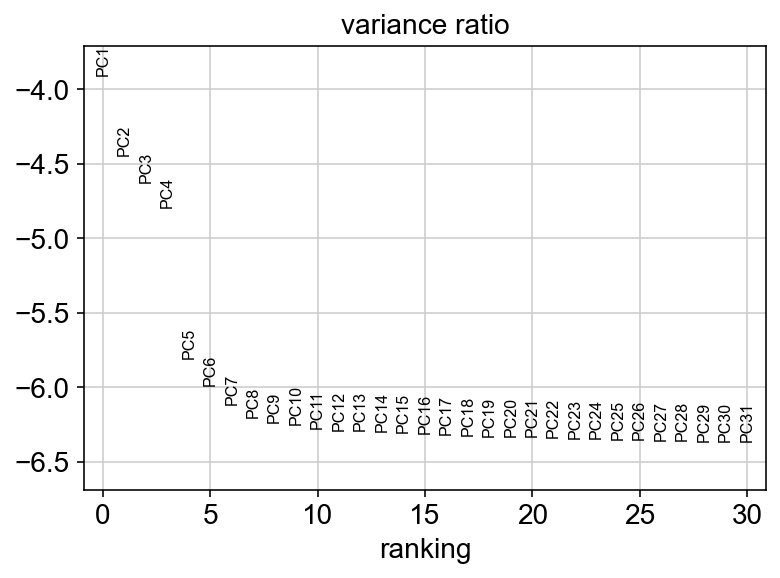

In [45]:
sc.pl.pca_variance_ratio(adata, log= True) 

**shows that the first component has the most variance compared to the other principal components**

                                we should choose 10 principal components

Save the result.

In [46]:
adata.write(results_file)

In [47]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# Clustering of the Cells

* define subpopulation of cells with similar expression profiles **with clustering**

* summarizes data 

* describe population heterogenity with discrete and understandable labels

* works similar to K-nearest neighbor graph (KNN)

1. **Computation of neighborhood graph**
    * each point is a cell and neighbors are other cells having similar expression patterns 
    

2. **Clustering of neighborhood graph**
    * graph is partitioned into communities where they have more similar expression patterns to those cells in the group than other cells 
    
    * each commumity is a **cluster** 

## Computation of Neighborhood Graph

In [48]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs= 10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [49]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### How is neighborhood graph is stored?

`neighbors` stored in `uns` 
* distances between cells & weighted adjency matrix between cells 

## Visualization of Neighborhood Graph

* to **visualize neighborhood graph** ---> **nonlinear dimensional reduction techniques** this is to place similar cells together in low dimensional space, cells that will be in the same clusters in high dimensional space should also be in the same clusters in low dimensional space
    * **t-SNE**(t-distributed stochastic neighborhood embedding)
    * **UMAP** 
UMAP is used because preserves trajectories and accomodates new Data 

In [50]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


### How is the UMAP reduction stored in Anndata

In [51]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

in `obsm` stored as `X_umap`

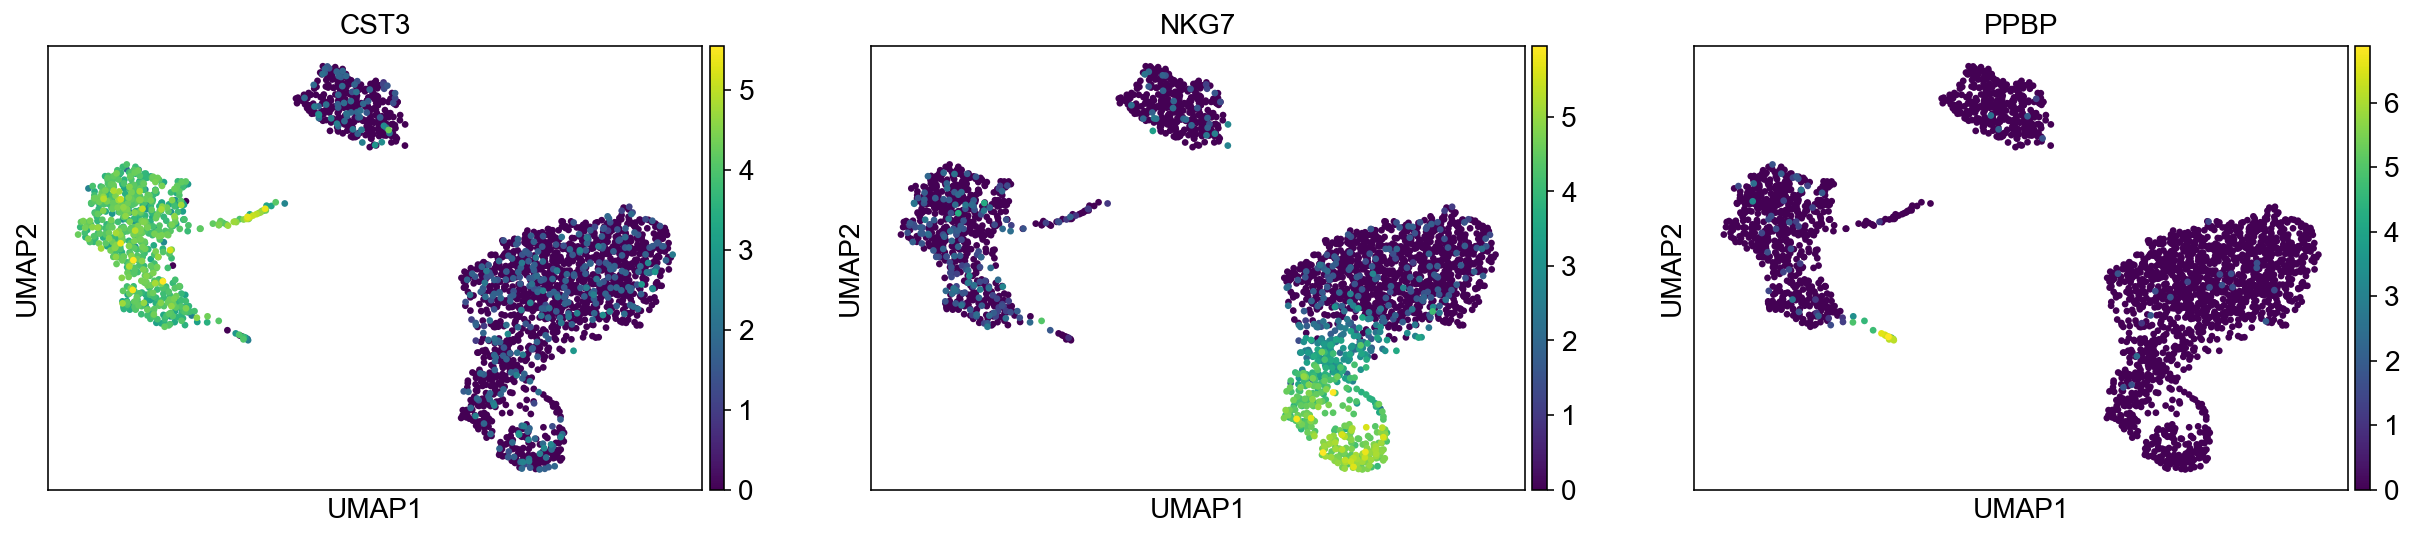

In [52]:
sc.pl.umap(adata, color = ['CST3', 'NKG7', 'PPBP'])

Clusters are idenitifiable on the graphs and with the `NKG7` you can distinguish each of the blobs for UMAP2 (y-axis) but on the `PPBP` you can't tell much of a difference between the blobs. They seem to be linked to PC's because the `CST3` was best distinguished in PC1 and is best described in UMAP1 and same respectively for `NGK7` and PC2

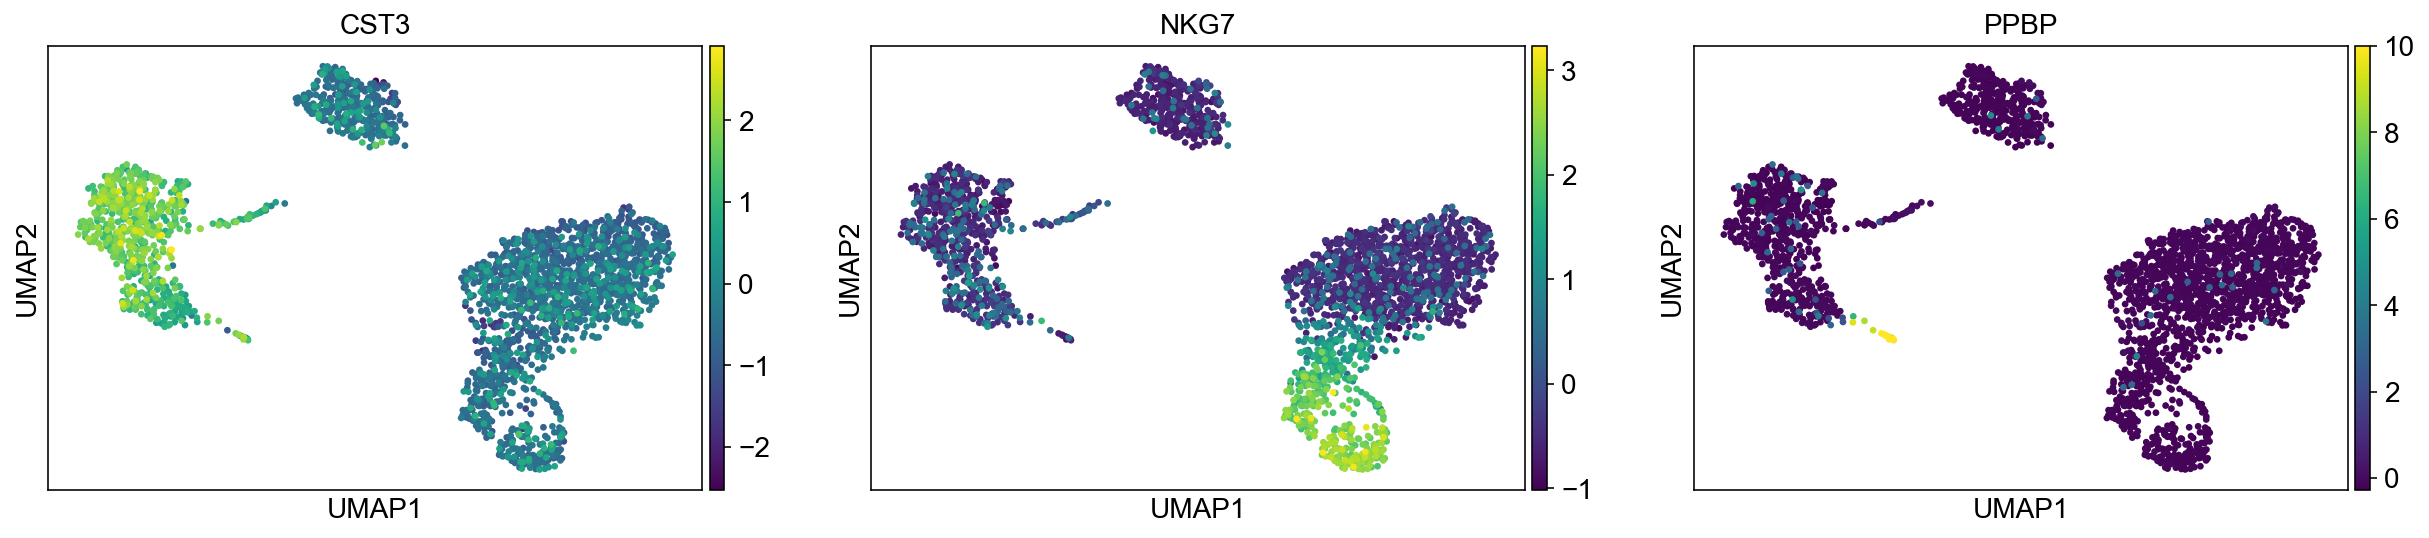

In [53]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering of the neighborhood graph

**Community detection algorithms** to define clusters within neighborhood graph

* **SLM**

* **Louvain**

* **Leiden algorithm**

Louvain clustering method reccomended(iteratively group cells together while optimizing standard modularity function)

`for single cell datasets of 3K cells, use resolution value between 0.4 and 1.2 and larger datasets, the optimal resultion will be higher`

In [54]:
sc.tl.louvain(adata, resolution=0.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


### How is the clustering information stored in Anndata object?

In [55]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'louvain'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

* extra column in `obs` with cluster id for each cell

In [56]:
adata.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACATACAACCAC-1      781                779        2419.0             73.0   
AAACATTGAGCTAC-1     1352               1352        4903.0            186.0   
AAACATTGATCAGC-1     1131               1129        3147.0             28.0   
AAACCGTGCTTCCG-1      960                960        2639.0             46.0   
AAACCGTGTATGCG-1      522                521         980.0             12.0   
...                   ...                ...           ...              ...   
TTTCGAACTCTCAT-1     1155               1153        3459.0             73.0   
TTTCTACTGAGGCA-1     1227               1224        3443.0             32.0   
TTTCTACTTCCTCG-1      622                622        1684.0             37.0   
TTTGCATGAGAGGC-1      454                452        1022.0             21.0   
TTTGCATGCCTCAC-1      724                723        1984.0             16.0   

                  pct_counts_mt louvain  
AAACATACAACCAC-1       3.017776       0  
AAACATTGAGCTAC-1       3.793596       3  
AAACATTGATCAGC-1       0.889736       1  
AAACCGTGCTTCCG-1       1.743085       2  
AAACCGTGTATGCG-1       1.224490       6  
...                         ...     ...  
TTTCGAACTCTCAT-1       2.110436       2  
TTTCTACTGAGGCA-1       0.929422       3  
TTTCTACTTCCTCG-1       2.197150       3  
TTTGCATGAGAGGC-1       2.054795       3  
TTTGCATGCCTCAC-1       0.806452       1  

[2638 rows x 6 columns]

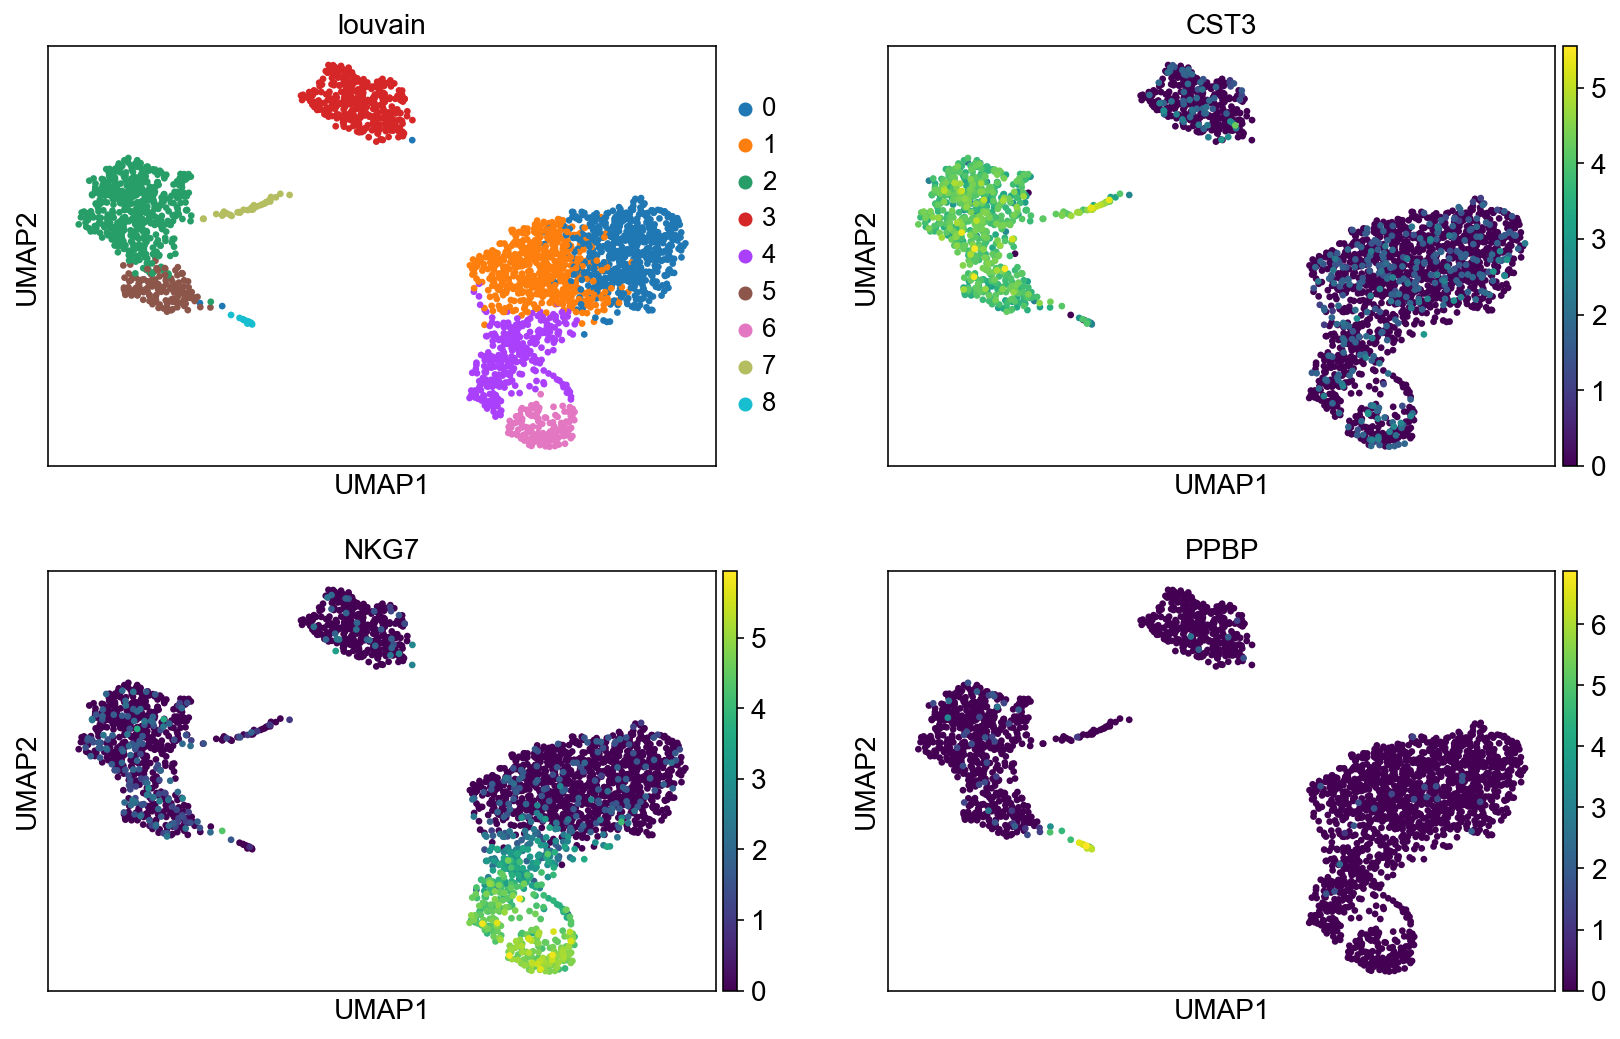

In [57]:
sc.pl.umap(adata, color= ['louvain', 'CST3', 'NKG7', 'PPBP'], ncols= 2)

In [58]:
adata.write(results_file)

### How many clusters have been identified? Do they fit with the ones quickly identified with UMAP plots? 

9 clusters are found and corresenpong to the one in the UMAP plots

# Finding Marker Genes

* identify the genes that drive the separation btwn clusters ---> **marker genes**
    * **marker genes** can be used to **assign cell type** to each cluster based on functional annotation & **identify subtle differences** btwn clusters based on the behaviors of genes in affected pathways
        * detected by their **differential expresssion btwn clusters**  
            * more strongly DE genes are more likely to cause clustering of cells 
            * to **qauntify differences in expression profiles**
                * t-Test
                * Wilcoxon rank sum test
                
    

 ## Using t-Test

In [59]:
sc.tl.rank_genes_groups(adata, 'louvain', n_genes = 100 ,method = 't-test')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


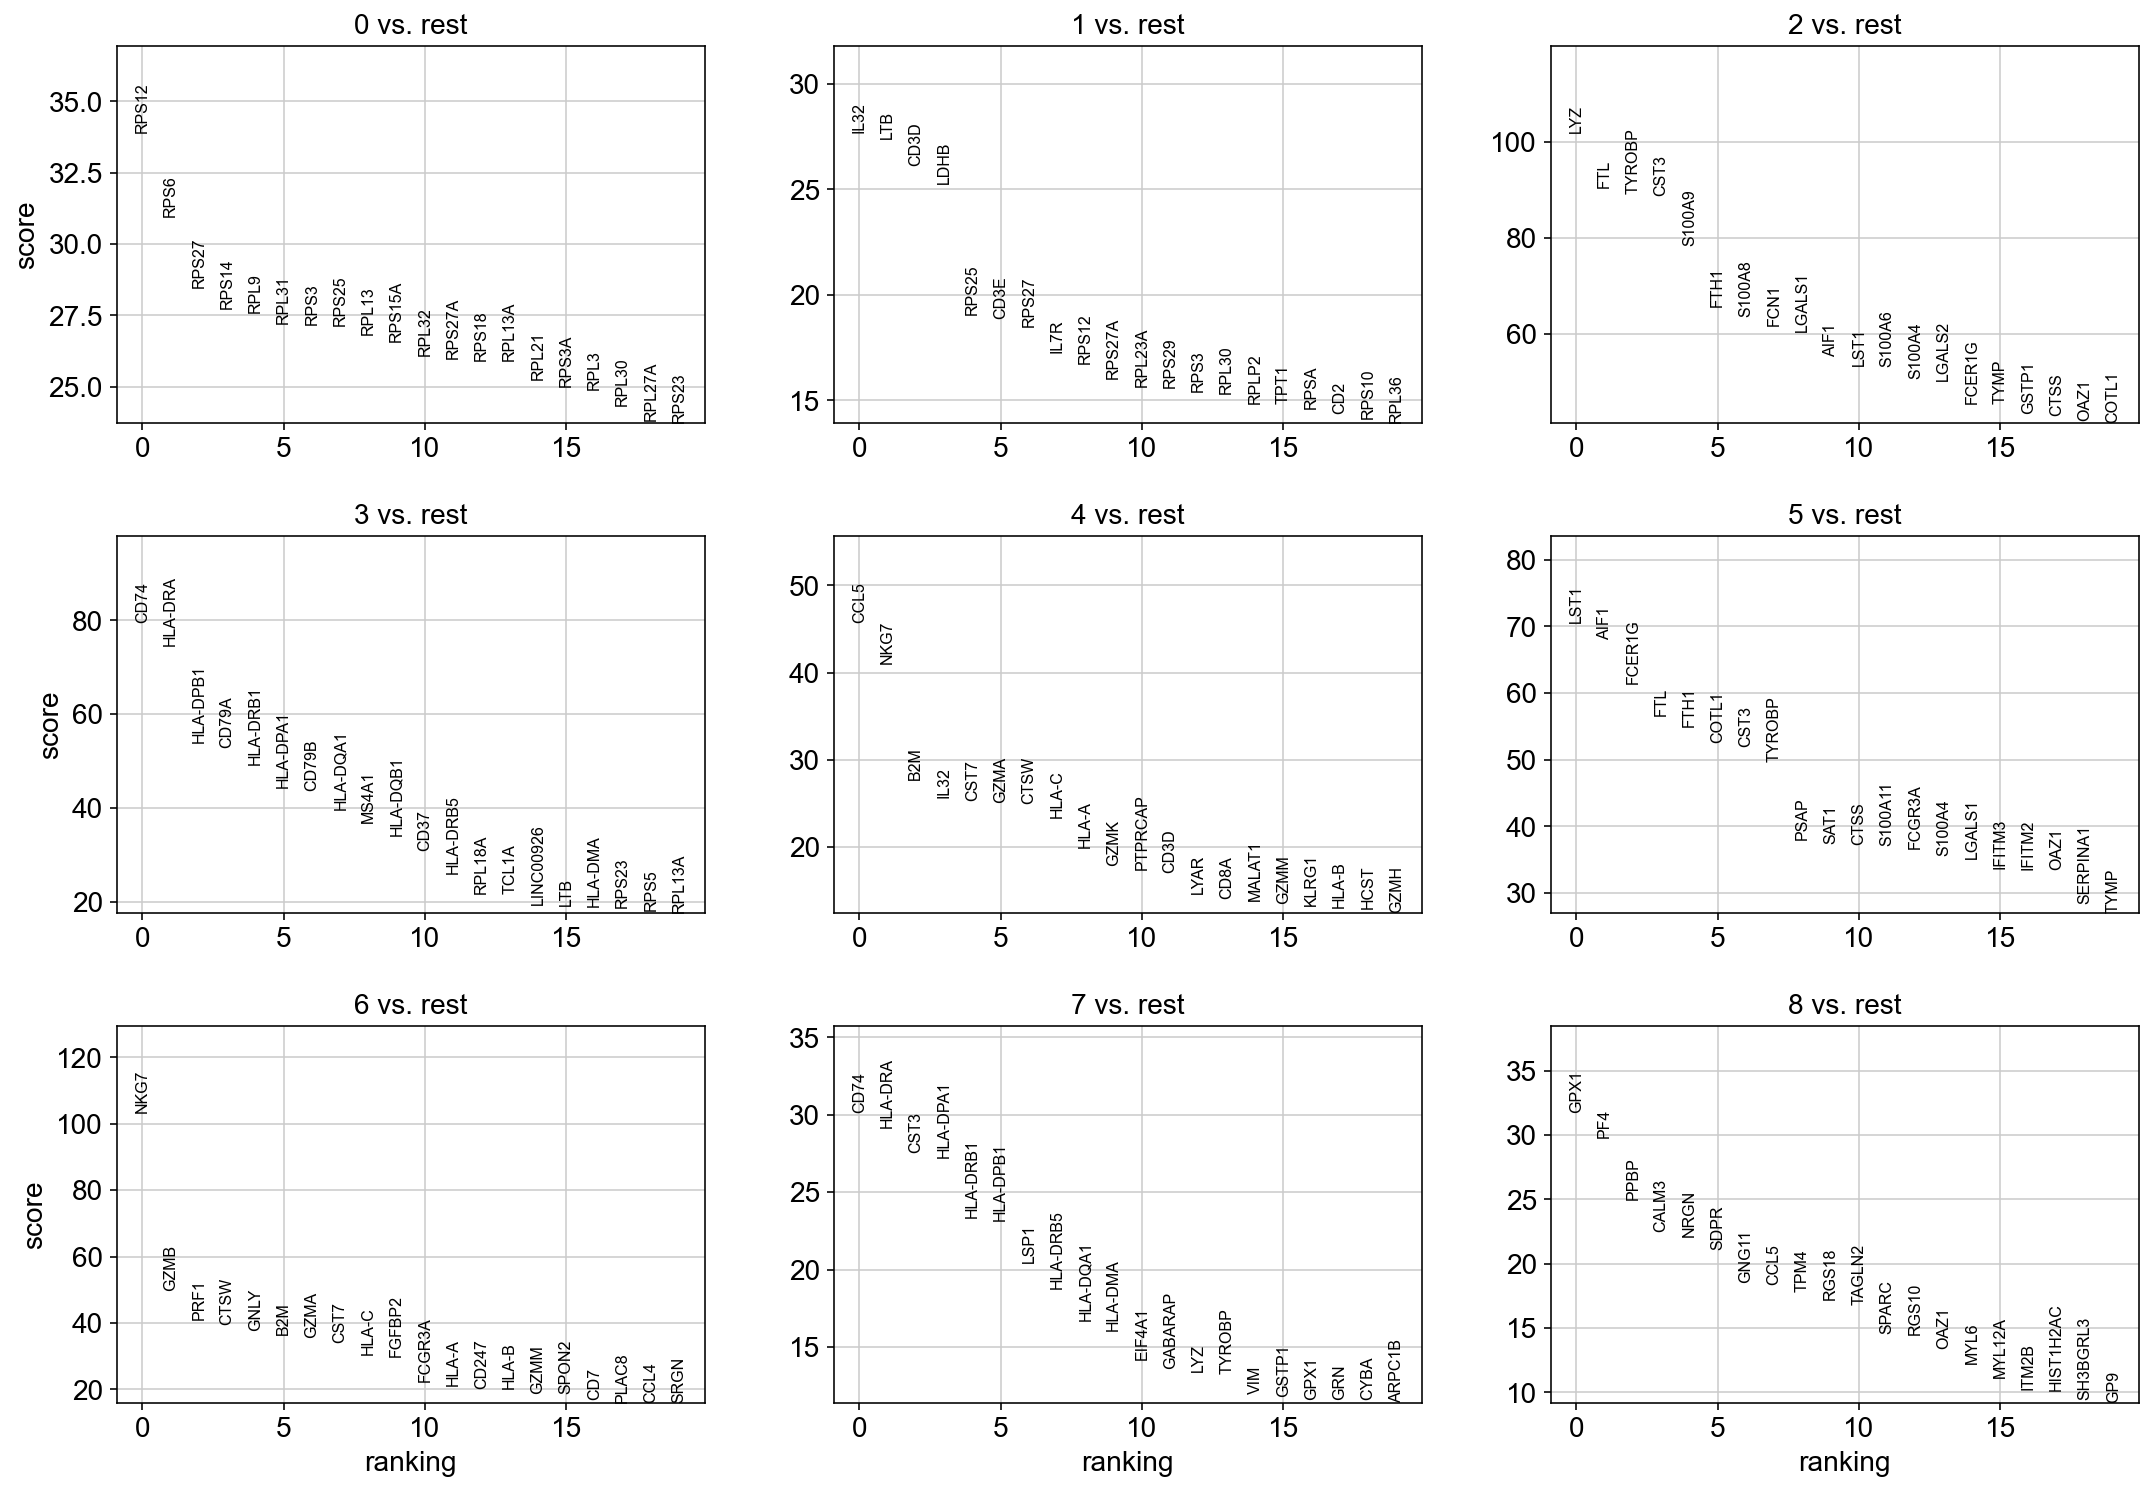

In [60]:
sc.pl.rank_genes_groups(adata, ncols = 3, sharey = False)

In [64]:
sc.settings.verbosity = 2  # reduce the verbosity

### Reading into adata.uns to find the rank_gene_groups and then turning that into a Data Frame

In [83]:
adata = sc.read(results_file)

In [87]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(8)

0      1       2         3      4       5     6         7      8
0  RPS12   IL32     LYZ      CD74   CCL5    LST1  NKG7      CD74   GPX1
1   RPS6    LTB     FTL   HLA-DRA   NKG7    AIF1  GZMB   HLA-DRA    PF4
2  RPS27   CD3D  TYROBP  HLA-DPB1    B2M  FCER1G  PRF1      CST3   PPBP
3  RPS14   LDHB    CST3     CD79A   IL32     FTL  CTSW  HLA-DPA1  CALM3
4   RPL9  RPS25  S100A9  HLA-DRB1   CST7    FTH1  GNLY  HLA-DRB1   NRGN
5  RPL31   CD3E    FTH1  HLA-DPA1   GZMA   COTL1   B2M  HLA-DPB1   SDPR
6   RPS3  RPS27  S100A8     CD79B   CTSW    CST3  GZMA      LSP1  GNG11
7  RPS25   IL7R    FCN1  HLA-DQA1  HLA-C  TYROBP  CST7  HLA-DRB5   CCL5

### Are CST3, NKG7 and PPBP in the set of marker genes and what are they assigned to? 

* `CST3` : 2, 5, 6


* `NKG7` : 4, 6


* `PPBP` : 8 

In [94]:
sc.settings.verbosity = 2  # reduce the verbosity

## Using Wilcox rank-sum Test

* pairwise compairisms btwn groups of observations
* asses separation btwn expression distributions of diff't clusers 

In [95]:
sc.tl.rank_genes_groups(adata, 'louvain', use_raw = True, n_genes =100, method = 'wilcoxon')

ranking genes
    finished (0:00:03)


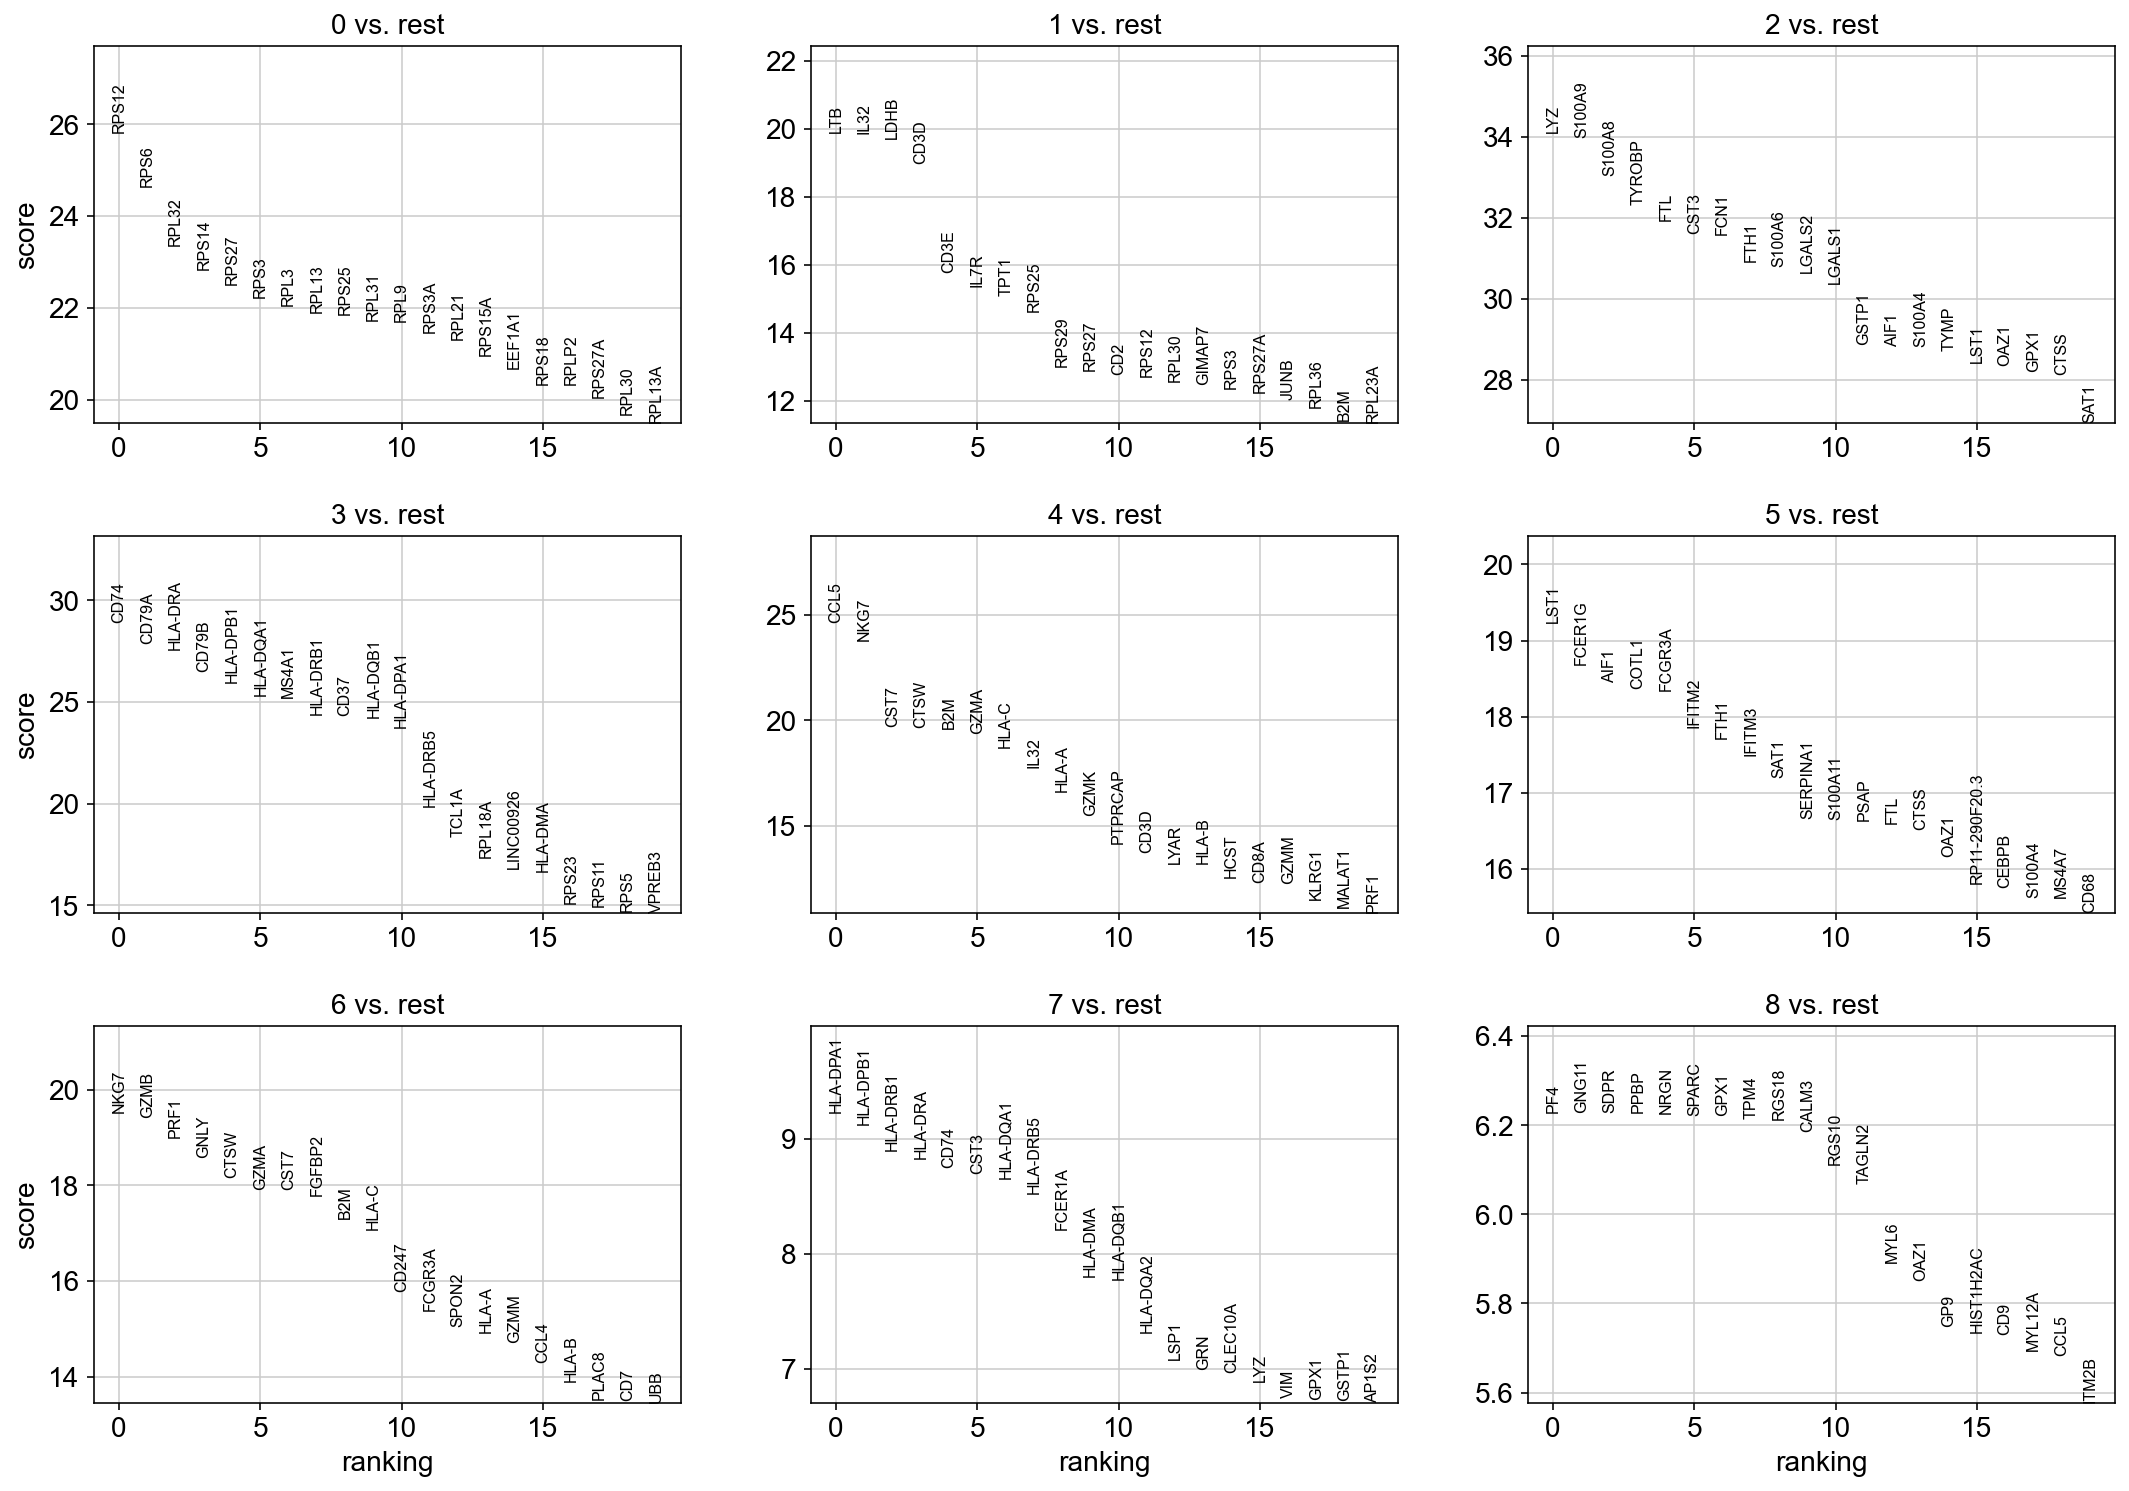

In [96]:
sc.pl.rank_genes_groups(adata, n_genes = 20, ncols = 3, sharey = False)

In [99]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0      1       2         3      4         5       6         7      8
0  RPS12    LTB     LYZ      CD74   CCL5      LST1    NKG7  HLA-DPA1    PF4
1   RPS6   IL32  S100A9     CD79A   NKG7    FCER1G    GZMB  HLA-DPB1  GNG11
2  RPL32   LDHB  S100A8   HLA-DRA   CST7      AIF1    PRF1  HLA-DRB1   SDPR
3  RPS14   CD3D  TYROBP     CD79B   CTSW     COTL1    GNLY   HLA-DRA   PPBP
4  RPS27   CD3E     FTL  HLA-DPB1    B2M    FCGR3A    CTSW      CD74   NRGN
5   RPS3   IL7R    CST3  HLA-DQA1   GZMA    IFITM2    GZMA      CST3  SPARC
6   RPL3   TPT1    FCN1     MS4A1  HLA-C      FTH1    CST7  HLA-DQA1   GPX1
7  RPL13  RPS25    FTH1  HLA-DRB1   IL32    IFITM3  FGFBP2  HLA-DRB5   TPM4
8  RPS25  RPS29  S100A6      CD37  HLA-A      SAT1     B2M    FCER1A  RGS18
9  RPL31  RPS27  LGALS2  HLA-DQB1   GZMK  SERPINA1   HLA-C   HLA-DMA  CALM3

### Are CST3, NKG7 and PPBP in the set of marker genes and what are they assigned to? 

* `CST3`: 2, 7 **does not have `CST3` in 5**


* `NKG7`: 4, 6


* `PPBP`: 8

Save the Result. 

In [101]:
adata.write(results_file)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit

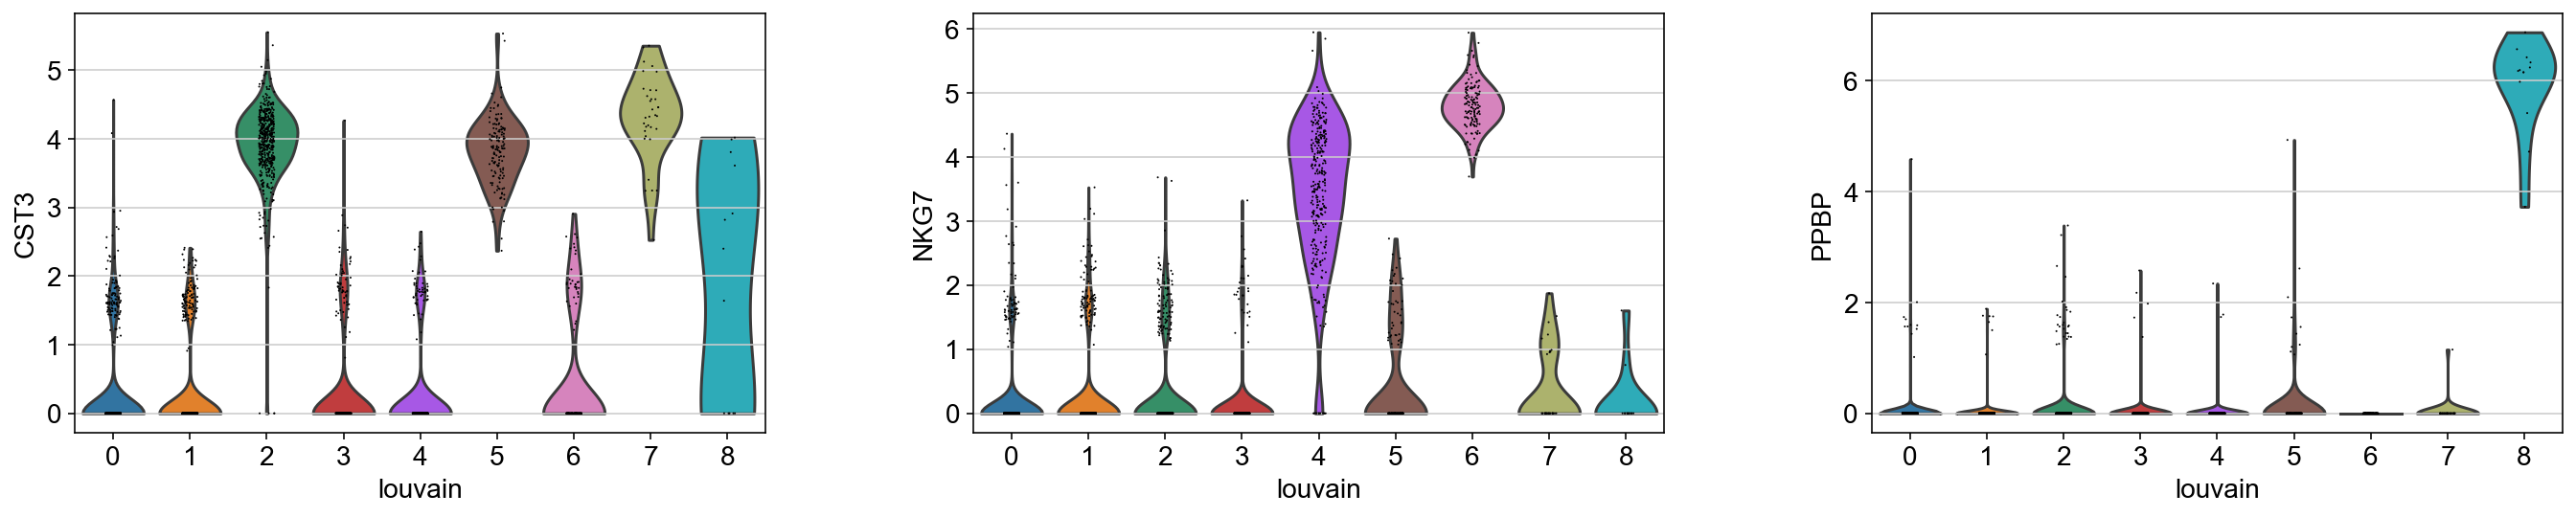

In [103]:
sc.pl.violin(adata, keys = ['CST3', 'NKG7', 'PPBP'], groupby = 'louvain')

* `CST3` more expressed in 2, 5, 7 (also kinda 8?)


* `NKG7` more expressed in 4, 6


* `PPBP` more expressed in 8

## Visualization of expression of marker genes

* marker genes should be more expressedd in clusters where they are markers --> ✨ MORE VISUALIZATIONS ✨

### Expression of the top marker genes in each cluster

**First way to visualize the expession of the top marker genes:**
* look at the distribution of the expression of each marker gene in cells for each cluster

In [136]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(1)

0    1    2     3     4     5     6         7    8
0  RPS12  LTB  LYZ  CD74  CCL5  LST1  NKG7  HLA-DPA1  PF4

In [152]:
top_marker_genes = ['RPS12', 'LTB', 'LYZ', 'CD74', 'CCL5','LST1', 'NKG7', 'HLA-DPA1', 'PF4']

In [153]:
adata.var_names

Index(['TNFRSF4', 'CPSF3L', 'ATAD3C', 'C1orf86', 'RER1', 'TNFRSF25', 'TNFRSF9',
       'CTNNBIP1', 'SRM', 'UBIAD1',
       ...
       'DSCR3', 'BRWD1', 'BACE2', 'SIK1', 'C21orf33', 'ICOSLG', 'SUMO3',
       'SLC19A1', 'S100B', 'PRMT2'],
      dtype='object', length=1838)

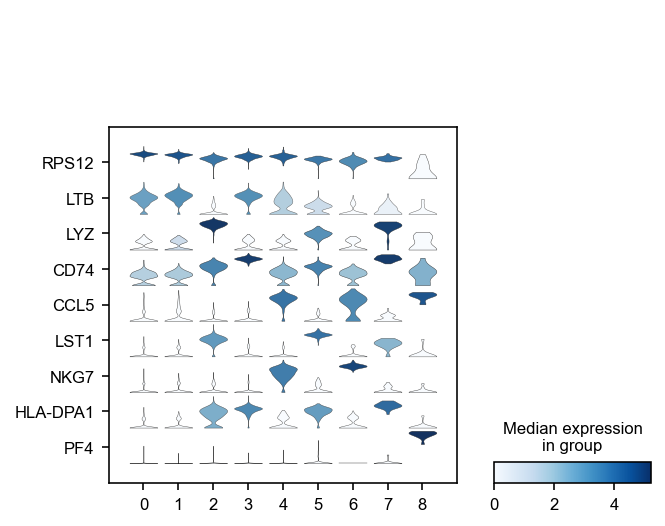

In [164]:
sc.pl.stacked_violin(adata, var_names = top_marker_genes , groupby = 'louvain', num_categories = 8, use_raw = True, swap_axes = True)

>* LDHB, LYZ and CD74, even if they are top markers genes for the cluster 0, 1, 2 respectively, are also expressed in all other clusters (and also found in the top 100 marker genes for other clusters), but with higher level in the cluster for they are markers.

>* CCL5, LST1, NKG7 and HLA-DPA1 are not expressed in all clusters but also not only in the one they are markers.

>* PF4 is only expressed in cluster 7.

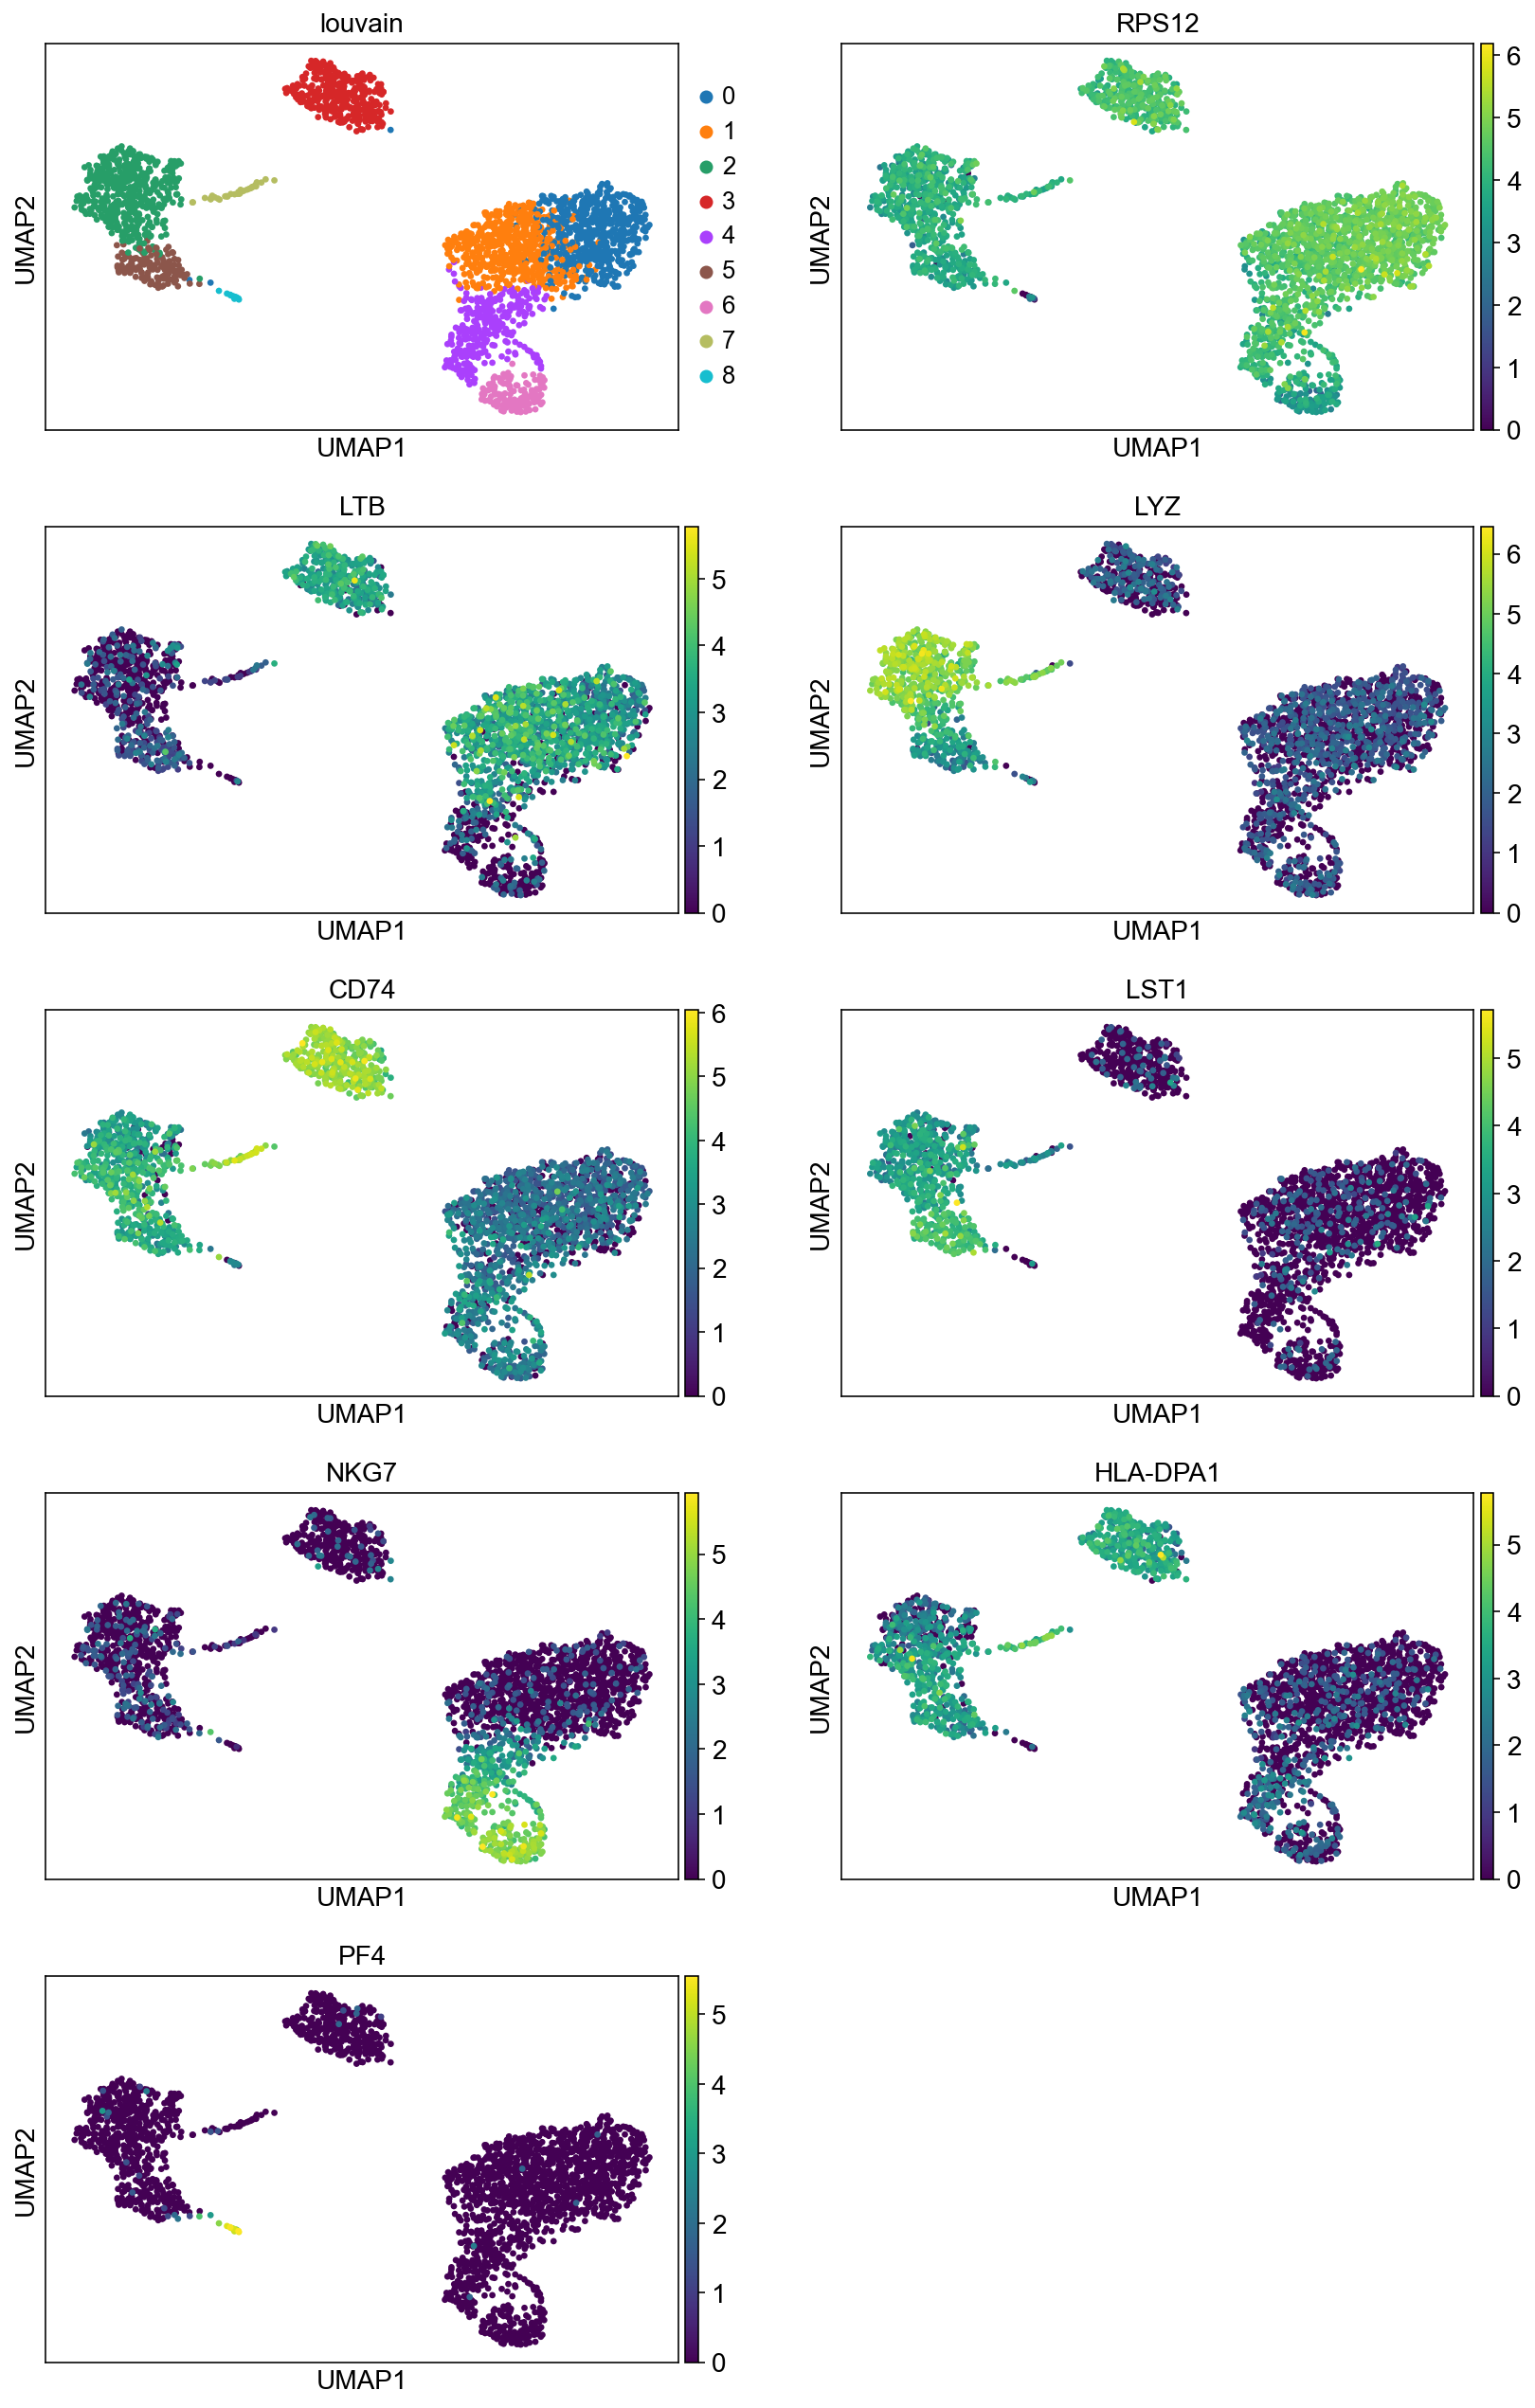

In [155]:
sc.pl.umap(adata, color= ['louvain', 'RPS12', 'LTB', 'LYZ', 'CD74', 'LST1', 'NKG7', 'HLA-DPA1', 'PF4'], ncols= 2)

Top marker genes are associated to their clusters but for physically close clusters, the differences are not so obvious.

### Expression of the top 20 marker genes in cells for each cluster

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain']`


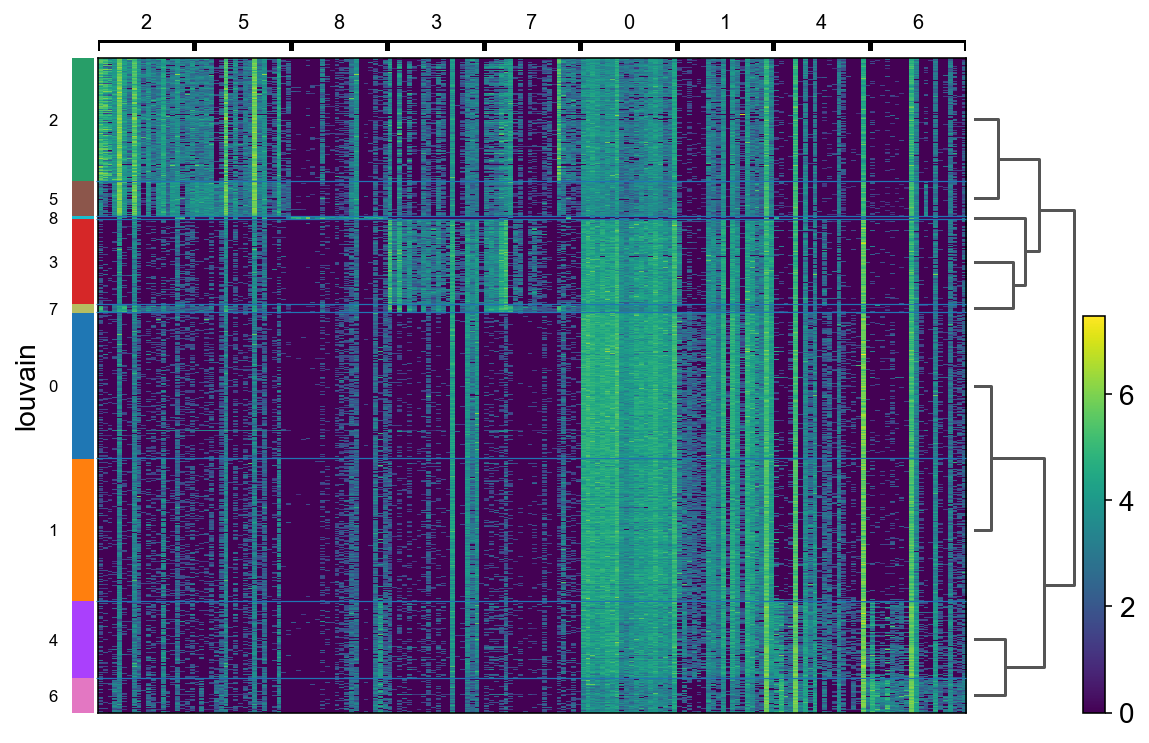

In [156]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes = 20)

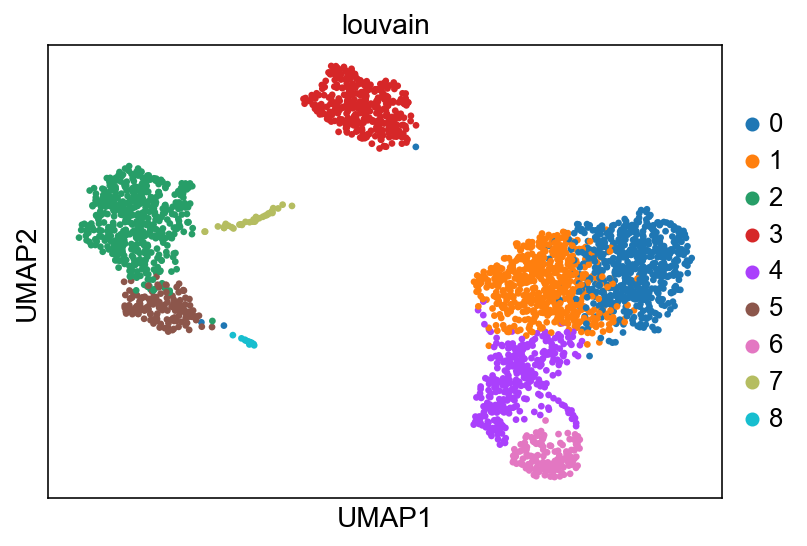

In [157]:
sc.pl.umap(adata, color= ['louvain'])

looking at the **neighborhood graph** you see that

* 2, 5, 7, 8 are together in the cluster
* 3 is alone
* 0,1,4, 6 are together in the cluster

And then on the **heat map**

* 2, 5, 7 is together but separated from 8
* 3 is close to 7 which is different
* 0,1, 4, 6 is together as expected

## Comparison of marker genes btwn clusters

find marker genes distinguishing one given cluster from one or several clusters

In [158]:
sc.tl.rank_genes_groups(adata, groupby= 'louvain',groups = ['0'] , reference = '1', n_genes = 100, method = 'wilcoxon')

ranking genes
    finished (0:00:02)


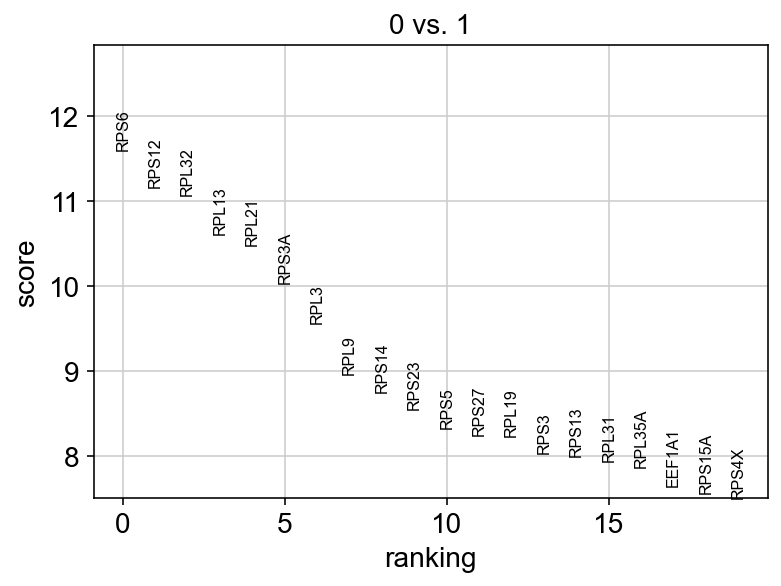

In [159]:
sc.pl.rank_genes_groups(adata, n_genes = 20, sharey = False)

In this graph are the marker genes distinguishing cluster 0 from cluster 1, ranked based on their difference of expression of the genes between cells in both clusters. 

So `RPS6` is the most differentially expressed gene between cells in cluster 0 and cells in cluster 1, even though it was not in the set of top marker genes for cluster 0.

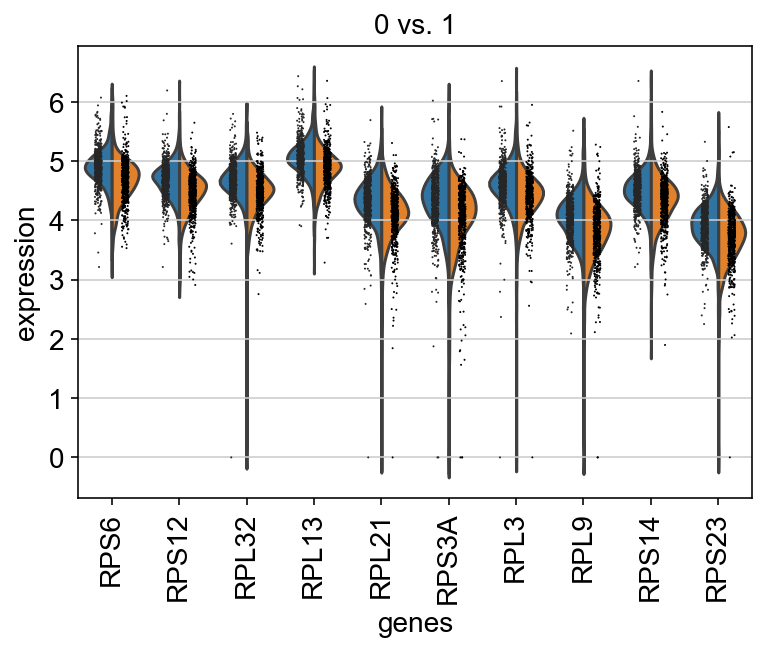

In [160]:
sc.pl.rank_genes_groups_violin(adata,n_genes = 10 , use_raw = True)

In [161]:
adata = sc.read(results_file)

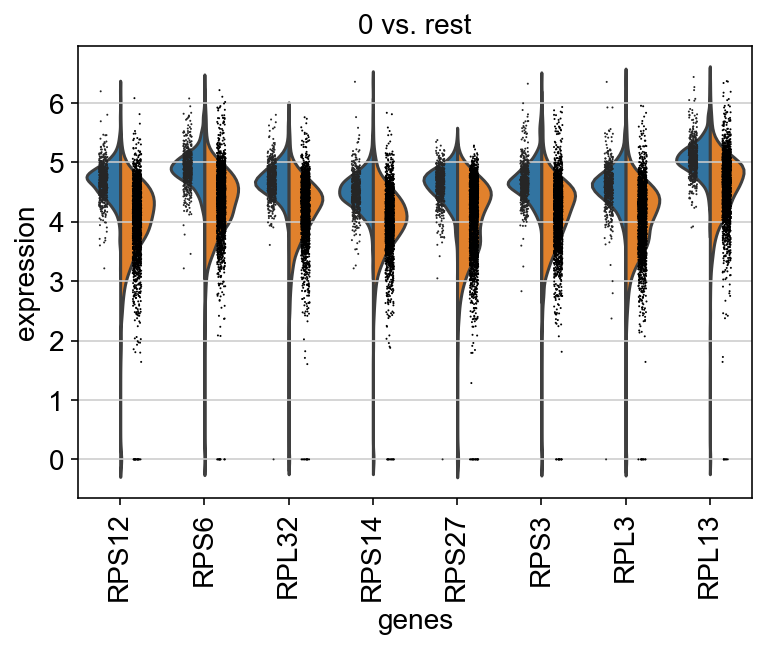

In [162]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [163]:
top_marker_genes

['RPS12', 'LTB', 'LYZ', 'CD74', 'CCL5', 'LST1', 'NKG7', 'HLA-DPA1', 'PF4']

| Gene          | Cell          | 
| ------------- |:-------------:| 
| RSP12         | CD4+ T cells  | 
| LTB           | B cell | 
| LYZ           | CD14+ Monocytes | 
| CD74          | Naive B cell |
| CCL5          | CD8+ T cells |
| LST1          | Non classical Monocyte |
| NKG7          | Natural killer (NK) cells |
| HLA-DPA1      | Myeloid | 
| PF4           | Basophil | 

In [165]:
new_cluster_names = [
    'CD4 T', 'B',
    'CD 14 Monocytes', 'Naive B',
    'CD8 T', 'Non classical Monocyte', 'NK',
    'Myeloid', 'Basophil']
adata.rename_categories('louvain', new_cluster_names)

In [167]:
adata.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACATACAACCAC-1      781                779        2419.0             73.0   
AAACATTGAGCTAC-1     1352               1352        4903.0            186.0   
AAACATTGATCAGC-1     1131               1129        3147.0             28.0   
AAACCGTGCTTCCG-1      960                960        2639.0             46.0   
AAACCGTGTATGCG-1      522                521         980.0             12.0   
...                   ...                ...           ...              ...   
TTTCGAACTCTCAT-1     1155               1153        3459.0             73.0   
TTTCTACTGAGGCA-1     1227               1224        3443.0             32.0   
TTTCTACTTCCTCG-1      622                622        1684.0             37.0   
TTTGCATGAGAGGC-1      454                452        1022.0             21.0   
TTTGCATGCCTCAC-1      724                723        1984.0             16.0   

                  pct_counts_mt          louvain  
AAACATACAACCAC-1       3.017776            CD4 T  
AAACATTGAGCTAC-1       3.793596          Naive B  
AAACATTGATCAGC-1       0.889736                B  
AAACCGTGCTTCCG-1       1.743085  CD 14 Monocytes  
AAACCGTGTATGCG-1       1.224490               NK  
...                         ...              ...  
TTTCGAACTCTCAT-1       2.110436  CD 14 Monocytes  
TTTCTACTGAGGCA-1       0.929422          Naive B  
TTTCTACTTCCTCG-1       2.197150          Naive B  
TTTGCATGAGAGGC-1       2.054795          Naive B  
TTTGCATGCCTCAC-1       0.806452                B  

[2638 rows x 6 columns]

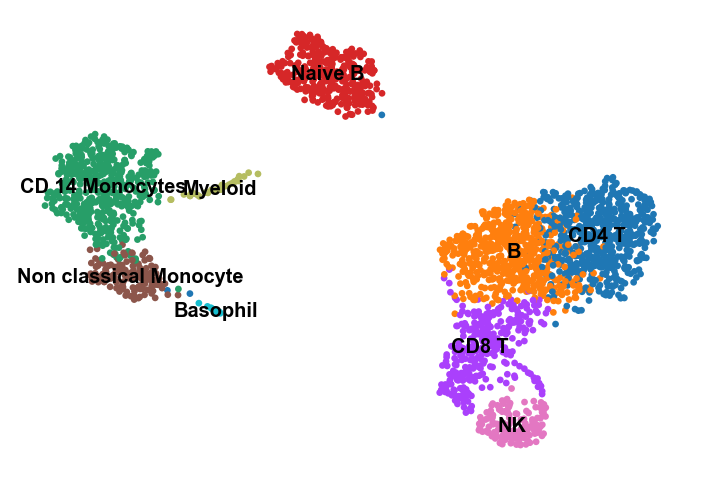

In [173]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False)

T cells (CD4+ and CD8+) are clustered together with NK cells with also B cells?  

Monocytes cells (CD14+ and FCGR3A+) are close to each others, with Myeloid and Basophil.

Naive B cells are physically independent.

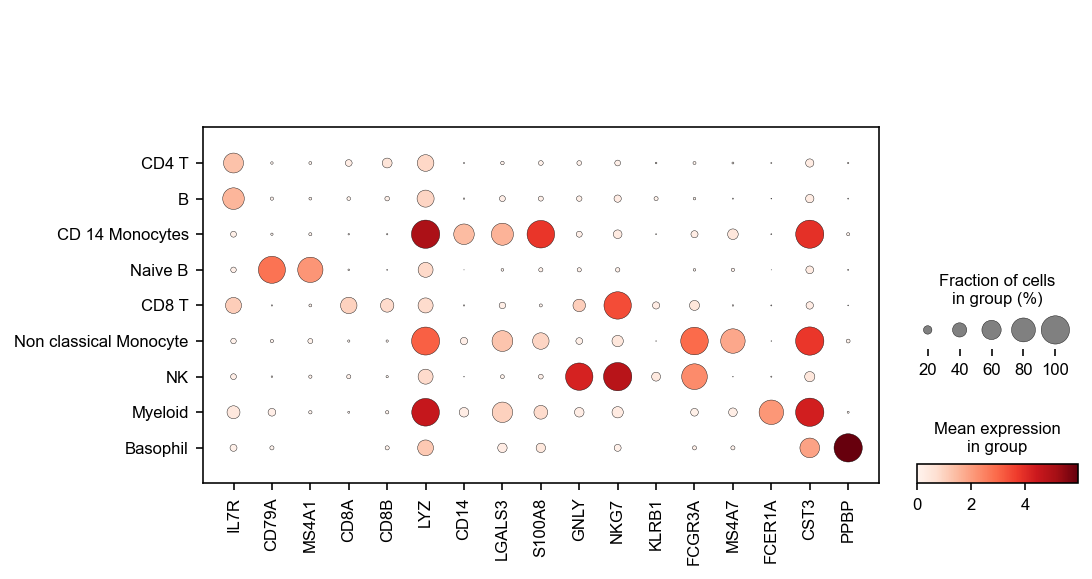

In [174]:
sc.pl.dotplot(adata, marker_genes, groupby='louvain')

# DONE :) CONCLUSION PLUS WRITING BACK TO FILE

In [175]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'louvain'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [176]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading


In [177]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

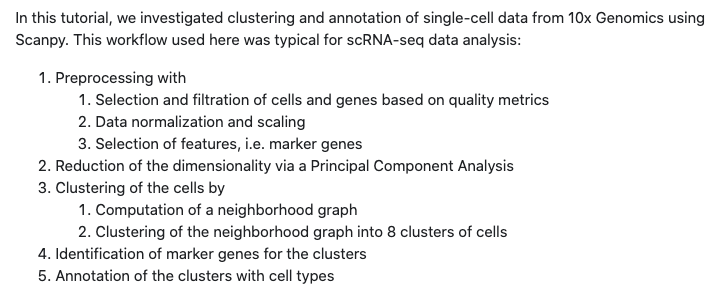

# More Resources to Learn/ References

https://training.galaxyproject.org/training-material/topics/transcriptomics/tutorials/scrna-scanpy-pbmc3k/tutorial.html#conclusion

https://training.galaxyproject.org/training-material/topics/transcriptomics/tutorials/scrna-raceid/tutorial.html

https://scanpy.discourse.group/

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

https://anndata.readthedocs.io/en/latest/anndata.AnnData.uns.html

https://www.proteinatlas.org/humanproteome/celltype

https://www.youtube.com/watch?v=aZIauqUp0oQ&t=17s&ab_channel=RebeccaJCarlson

https://scanpy.readthedocs.io/en/stable/index.html